In [2]:
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import albumentations as A
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Lambda
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adadelta, Adagrad, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import train_test_split
import os
from sklearn.model_selection import KFold, StratifiedKFold
from collections import Counter
from skimage.transform import rescale, resize
import numpy as np
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.utils import to_categorical
import sklearn as sk
import scipy.ndimage as s
import warnings
warnings.filterwarnings('ignore')

In [4]:
wandb.login()

wandb: Currently logged in as: natkaha (use `wandb login --relogin` to force relogin)


True

In [5]:
tf.__version__

'2.1.0'

In [3]:
import tensorflow as tf
gpu_id = '1'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU.
    try:
        # Currently, memory growth needs to be the same across GPUs.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[int(gpu_id)], 'GPU')
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized.
        print('!!!!!!!!!!',e)    

In [5]:
epochs = 1000
batch_size = 125
margin = 1  # Margin for constrastive loss.

In [239]:
dataset_dir = u"./cropped_pollen_bayesian"
nb_classes = 0
pollen_real = []
target_real = []
for d, dirs, files in os.walk(dataset_dir):
#     print(d.split(os.path.sep)[-1])
    nb_classes += 1
    images = filter(lambda x: x.endswith('.png'), files)     
    for f in images: 
        path = os.path.join(d,f)
        img = Image.open(path)
        img = np.asarray(img, dtype='uint8')
        img = resize(img, (32, 32),
                       preserve_range=False,
                       anti_aliasing=True)        
        pollen_real.append(img)
        target_real.append(d.split(os.path.sep)[-1])      
pollen_real = np.array(pollen_real) 
target_real = np.array(target_real)
nb_classes -= 1 
counter = Counter(np.array(target_real))
print(counter)

Counter({'maple': 1149, 'willow': 815, 'birch': 657, 'alder': 468, 'linden': 337, 'pigweed': 317, 'sorrel': 271, 'nettle': 231, 'pine': 230, 'plantain': 217, 'grass': 213, 'mugwort': 118, 'hazel': 77})


In [248]:
english_to_latin = [['willow','Salix'],
['linden','Tilia'],
['alder','Alnus'],
['birch','Betula'],
['nettle','Urtica'],
['pigweed','Chenopodiaceae'],
['plantain','Plantago'],
['sorrel','Rumex'],
['grass','Poaceae'],
['pine','Pinus'],
['maple','Acer'],
['hazel','Corylus'],
['mugwort','Artemisia']]


In [249]:
english_to_latin = np.array(english_to_latin)

In [253]:
english_to_latin = dict(zip(english_to_latin[:,0], english_to_latin[:,1]))

In [252]:
english_to_latin[0][1]

'Salix'

In [255]:
target_new = []
for item in target_real:
    target_new.append(english_to_latin[item])
target = target_new
target = np.array(target)

In [256]:
target

array(['Betula', 'Betula', 'Betula', ..., 'Rumex', 'Rumex', 'Rumex'],
      dtype='<U14')

In [257]:
cats = np.unique(target)
di = dict(zip(cats,np.arange(len(cats))))

In [240]:
cats = np.unique(target_real)
di = dict(zip(cats,np.arange(len(cats))))

In [258]:
di

{'Acer': 0,
 'Alnus': 1,
 'Artemisia': 2,
 'Betula': 3,
 'Chenopodiaceae': 4,
 'Corylus': 5,
 'Pinus': 6,
 'Plantago': 7,
 'Poaceae': 8,
 'Rumex': 9,
 'Salix': 10,
 'Tilia': 11,
 'Urtica': 12}

In [259]:
pollen_X_train, pollen_X_val, pollen_y_train, pollen_y_val = train_test_split(pollen_real, target_real, test_size=0.15, random_state=23)
print(nb_classes)
target_new = []
for item in pollen_y_val:
    target_new.append(di[item])
pollen_y_val = target_new
pollen_y_val = np.array(pollen_y_val)
pollen_Y_val = to_categorical(pollen_y_val, nb_classes)

13


KeyError: 'birch'

In [260]:
pollen_X_train, pollen_X_val, pollen_y_train, pollen_y_val = train_test_split(pollen_real, target, test_size=0.15, random_state=23)
print(nb_classes)
target_new = []
for item in pollen_y_val:
    target_new.append(di[item])
pollen_y_val = target_new
pollen_y_val = np.array(pollen_y_val)
pollen_Y_val = to_categorical(pollen_y_val, nb_classes)

13


In [7]:
ind = np.where(pollen_y_train=='willow')
ind = ind[0][400:]
# print(len(ind))
pollen_X_train = np.delete(pollen_X_train,ind, axis=0)
pollen_y_train = np.delete(pollen_y_train,ind, axis=0)
ind = np.where(pollen_y_train=='birch')
ind = ind[0][400:]
# print(len(ind))
pollen_X_train = np.delete(pollen_X_train,ind, axis=0)
pollen_y_train = np.delete(pollen_y_train,ind, axis=0)
ind = np.where(pollen_y_train=='maple')
ind = ind[0][400:]
# print(len(ind))
pollen_X_train = np.delete(pollen_X_train,ind, axis=0)
pollen_y_train = np.delete(pollen_y_train,ind, axis=0)

In [261]:
pollen = pollen_X_train
target = pollen_y_train

In [94]:
target

array(['birch', 'pigweed', 'alder', ..., 'willow', 'sorrel', 'birch'],
      dtype='<U8')

In [138]:
cats = np.unique(target)
di = dict(zip(cats,np.arange(len(cats))))

In [243]:
di

{'alder': 0,
 'birch': 1,
 'grass': 2,
 'hazel': 3,
 'linden': 4,
 'maple': 5,
 'mugwort': 6,
 'nettle': 7,
 'pigweed': 8,
 'pine': 9,
 'plantain': 10,
 'sorrel': 11,
 'willow': 12}

In [262]:
target_new = []
for item in target:
    target_new.append(di[item])
target = target_new
target = np.array(target)
# target1 = np_utils.to_categorical(target.map(di))

In [122]:
target_new = []
for item in target:
    target_new.append(english_to_latin[item])
target = target_new
target = np.array(target)
# target1 = np_utils.to_categorical(target.map(di))

In [123]:
target

array(['Betula', 'Amaranthus', 'Alnus', ..., 'Salix', 'Rumex', 'Betula'],
      dtype='<U10')

In [10]:
train_data, test_data, y_train, y_test = train_test_split(pollen, target, test_size=0.2, random_state=23)

In [11]:
def datagen(dataset, flip=True, crop=False, rotate=True):
    for i,im in enumerate(dataset):
        flip=np.random.randint(2, size=1)
        
        if flip:
            print(flip)
            im=np.fliplr(im)
        crop=np.random.randint(2, size=1)
        if crop:
            print(crop)
            crop1=np.random.randint(20,50,size=1)
            crop1=100-crop1
            
            if (not flip):
                im=resize(im[0:(im.shape[0]*crop1//100)[0], (im.shape[1]-(im.shape[1]*crop1//100)[0]):im.shape[1],:], 
                            im.shape,mode='RGB', anti_aliasing=True)
            else:
                im=resize(im[0:(im.shape[0]*crop1//100)[0], 0:((im.shape[1]*crop1//100)[0]),:], 
                            im.shape,mode='RGB', anti_aliasing=True)
        rotate=np.random.randint(2, size=1)

        if rotate:
            angle=np.random.randint(5,size=1)
            im=s.interpolation.rotate(im,angle)
            im=sp.imresize(im, 
                            size=im.shape,mode='RGB', interp='bilinear')
        dataset[i]=im    
    return dataset 

In [12]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
    A.Rotate(),
    A.ShiftScaleRotate(scale_limit=0.0, rotate_limit=0)
])

In [13]:
def make_pairs(x, y, augmentation=False):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        if augmentation:
            transformed = transform(image=x1.astype('float32'))
            x1 = transformed["image"]
            transformed = transform(image=x2.astype('float32'))
            x2 = transformed["image"]
            
        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        if augmentation:
            transformed = transform(image=x1)
            x1 = transformed["image"]
            transformed = transform(image=x2)
            x2 = transformed["image"]
            
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(train_data, y_train, augmentation=True)

# make validation pairs
pairs_val, labels_val = make_pairs(test_data, y_test, augmentation=True)

# make test pairs
pairs_test, labels_test = make_pairs(pollen_X_val, pollen_y_val, augmentation=True) 

In [13]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [14]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

In [15]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

In [16]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

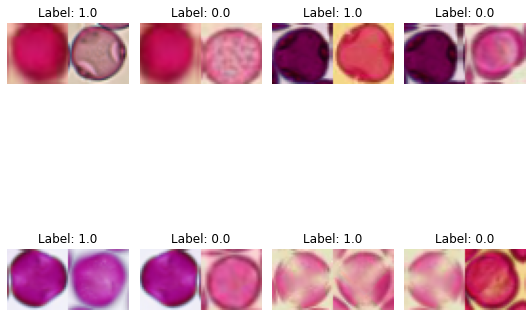

In [20]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=8, num_col=4)

In [263]:
# dataset_dir = u"./SELF_ATTENTION_GET_65k"
dataset_dir = u"./STYLE_GAN_GEN_65k"
# nb_classes = 0
# pollen_gan = []
target_gan = []
for d, dirs, files in os.walk(dataset_dir):
#     nb_classes += 1
    images = filter(lambda x: x.endswith('.jpeg'), files)     
    num = sum(1 for _ in filter(lambda x: x.endswith('.jpeg'), files))
    for i,f in enumerate(images): 
#         if (i < (num - 500) or num < 500):
        path = os.path.join(d,f)
#         img = Image.open(path)
#         img = np.asarray(img, dtype='uint8')
#         img = resize(img, (32, 32),
#                        anti_aliasing=True)        
#         pollen_gan.append(img)
        target_gan.append(d.split(os.path.sep)[-1])      
pollen_gan = np.array(pollen_gan) 
target_gan = np.array(target_gan)
# nb_classes -= 1 
counter = Counter(np.array(target_gan))
print(counter)

Counter({'pine': 5000, 'plantain': 5000, 'alder': 5000, 'maple': 5000, 'sorrel': 5000, 'nettle': 5000, 'pigweed': 5000, 'hazel': 5000, 'willow': 5000, 'linden': 5000, 'grass': 5000, 'mugwort': 5000, 'birch': 5000})


In [264]:
target_new = []
for item in target_gan:
    target_new.append(english_to_latin[item])
target_gan = target_new
target_gan = np.array(target_gan)

In [265]:
target_new = []
for item in target_gan:
    target_new.append(di[item])
target_gan = target_new
target_gan = np.array(target_gan)
# target1 = np_utils.to_categorical(target.map(di))

In [130]:
target_new = []
for item in target_gan:
    target_new.append(english_to_latin[item])
target_gan = target_new
target_gan = np.array(target_gan)
# target1 = np_utils.to_categorical(target.map(di))

In [74]:
pollen = pollen_gan
target = target_gan

In [75]:
target

array(['pine', 'pine', 'pine', ..., 'birch', 'birch', 'birch'],
      dtype='<U8')

In [23]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [17]:
# Provided two tensors t1 and t2
# Cosine distance = 1 - a * b/ ||a||*||b||
def cosine_distance(vects):
    """Find the cosine distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """
    eps = tf.keras.backend.epsilon()
    x, y = vects
    x_hat_inv_mag = tf.math.rsqrt(tf.clip_by_value(tf.reduce_sum(tf.square(x),1,keepdims=True),eps,float("inf")))

    x_i_inv_mag = tf.math.rsqrt(tf.clip_by_value(tf.reduce_sum(tf.square(y),1,keepdims=True),eps,float("inf")))
    dotted = tf.squeeze(
            tf.matmul(tf.expand_dims(x,1),tf.expand_dims(y,2)),[1,])

    return 1 - dotted * x_i_inv_mag * x_hat_inv_mag

In [23]:
nb_filters = [64, 64, 64, 64, 64]
# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2, 2]
# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3, 3, 3, 3, 3]
# input image dimensions
img_rows, img_cols = pollen.shape[1],pollen.shape[2]
print(img_rows,img_cols)
img_channels = 3

32 32


In [18]:
def triplet_loss(y_true, y_pred):
    """Calculates the constrastive loss.

  Arguments:
      y_true: List of labels, each label is of type float32.
      y_pred: List of predictions of same length as of y_true,
              each label is of type float32.

  Returns:
      A tensor containing constrastive loss as floating point value.
  """
    pos = (1 - y_true) * y_pred
    neg = y_true * y_pred

#     pos = tf.reduce_min(pos, axis=1, keepdims=True)
#     neg = tf.reduce_max(neg, axis=1, keepdims=True)
    return tf.math.reduce_mean(
        tf.math.maximum(margin + pos - neg, 0)
    ) 

In [19]:
def hard_triplet_loss(y_true, y_pred):
    """Calculates the constrastive loss.

  Arguments:
      y_true: List of labels, each label is of type float32.
      y_pred: List of predictions of same length as of y_true,
              each label is of type float32.

  Returns:
      A tensor containing constrastive loss as floating point value.
  """
    pos = (1 - y_true) * y_pred
    neg = y_true * y_pred

    pos = tf.reduce_max(pos, axis=1, keepdims=True)
    neg = tf.reduce_min(neg, axis=1, keepdims=True)
    return tf.math.reduce_mean(
        tf.math.maximum(margin + pos - neg, 0)
    ) 

In [20]:
def contrastive_loss(y_true, y_pred):
    """Calculates the constrastive loss.

  Arguments:
      y_true: List of labels, each label is of type float32.
      y_pred: List of predictions of same length as of y_true,
              each label is of type float32.

  Returns:
      A tensor containing constrastive loss as floating point value.
  """
    margin = 1.0
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )

In [21]:
from sklearn import metrics
def evaluate(centroids, centroid_labels):
    
    y_pred = np.zeros(len(pollen_y_val))

    for i,img in enumerate(pollen_X_val):
        y_pred[i] = get_class(img, centroids, centroid_labels)
#         print(y_pred[i].astype(int),pollen_y_val[i])
    y_pred = y_pred.astype(int)


    f1 = metrics.f1_score(pollen_y_val, y_pred, average="macro")
    acc = metrics.accuracy_score(pollen_y_val, y_pred)
    # print('acc', acc,'f1', f1)
    return acc, f1

In [22]:
import scipy as sp
def get_class(imgio, centroids, centroid_labels):

    X_encode = siamese.layers[2](tf.expand_dims(imgio,0))
#     X_norm = preprocessing.normalize(X_encode)
    X_matrix = np.tile(X_encode, (len(centroids), 1))
#     print(X_matrix)
    
    x = siamese.layers[3]([X_matrix, centroids])
    x = siamese.layers[4](x)
    probs = siamese.layers[5](x)

    probs = np.array(probs)
#     print(probs)    
    max = np.argmax(probs)
    y_pred = centroid_labels[max]
    
    return y_pred

In [151]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift, OPTICS, Birch
from sklearn import metrics
from sklearn import preprocessing
def get_centroids():
    
    X_encode = siamese.layers[2](pollen)
    X_norm = preprocessing.normalize(X_encode)
    
    kmeans = KMeans(n_clusters=100, random_state=0, max_iter=2000, 
                    algorithm='elkan').fit(preprocessing.normalize(X_norm))
    centroids = kmeans.cluster_centers_
    centroid_labels = np.zeros(len(kmeans.cluster_centers_))

    for j in range(len(kmeans.cluster_centers_)):
        min = float("inf")
        for i in range(X_norm.shape[0]):
            dist = np.linalg.norm(centroids[j]-X_norm[i])
            if min > dist:
                min = dist
                centroid_labels[j] = target[i]
    return centroids, centroid_labels

In [79]:
X_norm = preprocessing.normalize(X_gan_encode)

kmeans = KMeans(n_clusters=200, random_state=0, max_iter=2000, 
                algorithm='elkan').fit(preprocessing.normalize(X_norm))
centroids_gan = kmeans.cluster_centers_
centroid_gan_labels = np.zeros(len(kmeans.cluster_centers_))

for j in range(len(kmeans.cluster_centers_)):
    min = float("inf")
    for i in range(X_norm.shape[0]):
        dist = np.linalg.norm(centroids_gan[j]-X_norm[i])
        if min > dist:
            min = dist
            centroid_gan_labels[j] = target_gan[i]

In [156]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift, OPTICS, Birch
from sklearn import metrics
from sklearn import preprocessing
def get_gan_centroids():
    
    
    X_gan_encode = []
    for i in range(104):
        X_encode = siamese.layers[2](pollen_gan[625*(i):625*(i+1)])
        X_gan_encode.append(X_encode)
    X_gan_encode = np.array(X_gan_encode)   
    X_gan_encode = X_gan_encode.reshape((len(pollen_gan),50))
    
    X_encode = siamese.layers[2](pollen)
    X_encode = np.append(X_encode,X_gan_encode, axis=0)
    X_norm = preprocessing.normalize(X_encode)
    target_gan_real = np.append(target,target_gan)
    
    kmeans = KMeans(n_clusters=200, random_state=0, max_iter=2000, 
                    algorithm='elkan').fit(preprocessing.normalize(X_norm))
    centroids = kmeans.cluster_centers_
    centroid_labels = np.zeros(len(kmeans.cluster_centers_))

    for j in range(len(kmeans.cluster_centers_)):
        min = float("inf")
        for i in range(X_norm.shape[0]):
            dist = np.linalg.norm(centroids[j]-X_norm[i])
            if min > dist:
                min = dist
                centroid_labels[j] = target_gan_real[i]
    return centroids, centroid_labels

In [91]:
X_encode.shape

(6665600,)

In [93]:
    X_encode = siamese.layers[2](pollen)
    X_encode = np.append(X_encode,X_gan_encode, axis=0)
    print(X_encode.shape)
    X_norm = preprocessing.normalize(X_encode)

(68312, 50)


In [95]:
for i in [1,2,5,6,9,10,13,14,17,18,22]:
    print(siamese.layers[2].layers[i])

In [119]:
for i in [1,2,5,6,9,10,13,14,17,18,21]:
        print(siamese.layers[2].layers[i]

'contrastive'

In [ ]:
class DataGenerator(object):
    """docstring for DataGenerator"""
    def __init__(self, batch_sz, X_train, y_train, X_test, y_test):


        self.tr_pairs, self.tr_y = self.make_pairs(X_train, y_train)

        self.te_pairs, self.te_y = self.make_pairs(X_test, y_test)

        self.tr_pairs_0 = self.tr_pairs[:, 0]
        self.tr_pairs_1 = self.tr_pairs[:, 1]
        self.te_pairs_0 = self.te_pairs[:, 0]
        self.te_pairs_1 = self.te_pairs[:, 1]

        self.batch_sz = batch_sz
        self.samples_per_train  = (self.tr_pairs.shape[0]/self.batch_sz)*self.batch_sz
        self.samples_per_val    = (self.te_pairs.shape[0]/self.batch_sz)*self.batch_sz


        self.cur_train_index=0
        self.cur_val_index=0

    def make_pairs(x, y):
        """Creates a tuple containing image pairs with corresponding label.

        Arguments:
            x: List containing images, each index in this list corresponds to one image.
            y: List containing labels, each label with datatype of `int`.

        Returns:
            Tuple containing two numpy arrays as (pairs_of_samples, labels),
            where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
            labels are a binary array of shape (2len(x)).
        """

        num_classes = 13 #max(y) + 1
        digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

        pairs = []
        labels = []

        for idx1 in range(len(x)):
            # add a matching example
            x1 = x[idx1]
            label1 = y[idx1]
            idx2 = random.choice(digit_indices[label1])
            x2 = x[idx2]

            pairs += [[x1, x2]]
            labels += [1]

            # add a non-matching example
            label2 = random.randint(0, num_classes - 1)
            while label2 == label1:
                label2 = random.randint(0, num_classes - 1)

            idx2 = random.choice(digit_indices[label2])
            x2 = x[idx2]

            pairs += [[x1, x2]]
            labels += [0]

        return np.array(pairs), np.array(labels).astype("float32")

    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_sz
            if self.cur_train_index >= self.samples_per_train:
                self.cur_train_index=0
            yield ([    self.tr_pairs_0[self.cur_train_index:self.cur_train_index+self.batch_sz], 
                        self.tr_pairs_1[self.cur_train_index:self.cur_train_index+self.batch_sz]
                    ],
                    self.tr_y[self.cur_train_index:self.cur_train_index+self.batch_sz]
                )
            
    def next_val(self):
        while 1:
            self.cur_val_index += self.batch_sz
            if self.cur_val_index >= self.samples_per_val:
                self.cur_val_index=0
            yield ([    self.te_pairs_0[self.cur_val_index:self.cur_val_index+self.batch_sz], 
                        self.te_pairs_1[self.cur_val_index:self.cur_val_index+self.batch_sz]
                    ],
                    self.te_y[self.cur_val_index:self.cur_val_index+self.batch_sz]
                )

In [69]:
Counter()

# Baseline, Transfer learning, Fine-tuning

In [32]:
loss = hard_triplet_loss
# suffix = "_stylegan_65k_"+loss.__name__[:-5]
suffix = loss.__name__[:-5]
stage = "baseline_"
# stage = "fine_tuning"
# stage = "transfer_learning"
epochs = 280
batch_size = 256
margin = 1.0  # Margin for loss.
data_augmentation = True
if data_augmentation:
    suffix += "_aug"
# number of convolutional filters to use at each layer
nb_filters = [64, 64, 64, 64, 64, 64]
# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2, 2]
# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3, 3, 3, 3, 3, 3]
# input image dimensions
img_rows, img_cols = pollen.shape[1],pollen.shape[2]
print(img_rows,img_cols)
img_channels = 3

means_ac_bin = []
means_f1_bin = []
means_ac_full = []
means_f1_full = []


cv=0
kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(pollen, target):
# for i in range(1):
    print("!-----------------------"+str(cv+1)+"--------------------------!")

    
    inputs = layers.Input((img_rows, img_cols, img_channels))   
    for i in range(5):
        if i==0:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(inputs)
        else:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AveragePooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(50)(x)
    x = Activation('relu')(x)

    embedding_network = keras.Model(inputs, x)


    input_1 = layers.Input((img_rows, img_cols, img_channels))
    input_2 = layers.Input((img_rows, img_cols, img_channels))

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = Lambda(cosine_distance)([tower_1, tower_2])
    normal_layer = BatchNormalization()(merge_layer)
    output_layer = Dense(1, activation="sigmoid")(normal_layer)
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    
    if stage == "fine_tuning":
        initial_learning_rate = 1e-1
    else:    
        initial_learning_rate = 1e-1
    decay_steps = 40 #150
    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(
                      initial_learning_rate,
                      decay_steps))
#                     alpha=0.01))
    optimizer =  Adam(lr=initial_learning_rate)
    if stage == "transfer_learning":
        siamese = load_model("SiameseNN"+suffix+"1.hdf5", compile=False)
    if stage == "fine_tuning":
        siamese = load_model("SiameseNN_transfer_learning"+suffix+str(cv+1)+".hdf5", compile=False)
    print(not (stage=="transfer_learning"))
    for i in [1,2,5,6,9,10,13,14,17,18,22]:
        siamese.layers[2].layers[i].trainable = not (stage=="transfer_learning")
    siamese.compile(loss=loss, optimizer=optimizer, metrics=["accuracy",
                                               tfa.metrics.F1Score(num_classes=1, average='macro')])
    X_train = pollen[train]
    X_test = pollen[test]
    y_train = target[train]
    y_test = target[test]

    pairs_train, labels_train = make_pairs(X_train, y_train)

    pairs_val, labels_val = make_pairs(X_test, y_test)
    
    x_train_1 = pairs_train[:, 0]  
    x_train_2 = pairs_train[:, 1]    
    x_val_1 = pairs_val[:, 0]  
    x_val_2 = pairs_val[:, 1]    

    checkpointer = ModelCheckpoint(filepath="SiameseNN_"+stage+suffix+str(cv+1)+".hdf5", verbose=1, 
                                       save_best_only=True)
    es = EarlyStopping(
            monitor    = 'val_loss',
            patience   = 40,
            mode       = 'min'
        )   
    
    wandb.init(
      project="pollen-siameseNN",
      # Set entity to specify your username or team name
      # ex: entity="carey",
      config={
          "optimizer": "adam",
          "metric": ["accuracy","f1"],
          "epoch": epochs,
          "batch_size": batch_size,
          "augmentation": "True",
          "initial_lr": initial_learning_rate,
          "dist": "cosine_dist",
          "loss": loss.__name__+str(margin),
          "model": "MatchingNN-like+dense(50)",
          "freeze": "[1,2,5,6,9,10,13,14,17,18,22]",
          "weights": "SiameseNN_"+stage+suffix+str(cv+1)+".hdf5",
#           "lrscheduler":"CosineDecayRestarts(20 steps)"
#           "lrscheduler":"es"
      },
      tags=[suffix, stage+str(cv+1)], name='7th run')
    config = wandb.config   
                         
                      
                         
    if stage == "transfer_learning":
        history = siamese.fit(
            [x_train_1, x_train_2],
            labels_train,
            validation_data=([x_val_1, x_val_2], labels_val),
            batch_size=batch_size,
            epochs=epochs, 
            callbacks=[checkpointer, 
                       es,
#                      LearningRateScheduler(lr_decayed_fn), 
                     WandbCallback()]    
        )
    if stage == "fine_tuning":
        history = siamese.fit(
            [x_train_1, x_train_2],
            labels_train,
            validation_data=([x_val_1, x_val_2], labels_val),
            batch_size=batch_size,
            epochs=epochs, 
            callbacks=[checkpointer, 
#                      es, 
                     LearningRateScheduler(lr_decayed_fn),                        
                     WandbCallback()]    
        )
    if stage == "baseline_":
        history = siamese.fit(
            [x_train_1, x_train_2],
            labels_train,
            validation_data=([x_val_1, x_val_2], labels_val),
            batch_size=batch_size,
            epochs=epochs, 
            callbacks=[checkpointer, 
#                      es, 
                     LearningRateScheduler(lr_decayed_fn),                        
                     WandbCallback()]    
        )        
    
    siamese = load_model("SiameseNN_"+stage+suffix+str(cv+1)+".hdf5", compile=False)
    siamese.compile(loss=loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])
    
    results = siamese.evaluate([x_test_1, x_test_2], labels_test)
    print("Binary acc, f1:", results[1:])

    means_ac_bin.append(results[1])
    means_f1_bin.append(results[2])
    centroids, centroid_labels = get_centroids()
#     centroids, centroid_labels = centroids_gan, centroid_gan_labels
    score = evaluate(centroids, centroid_labels)
    print("Full acc, f1:", score)
    means_ac_full.append(score[0])
    means_f1_full.append(score[1])

    
#     model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
#               steps_per_epoch=len(X_train) / 32, epochs=nb_epoch, 
#               verbose=1, validation_data=(pollen_X_val, pollen_Y_val), 
#               callbacks=[checkpointer, 
#                          es, 
#                          LearningRateScheduler(lr_decayed_fn), 
#                          WandbCallback()])
    wandb.finish()
    cv+=1          
    
print('Crossvalidate Bin F1 score:',np.mean(means_f1_bin),'+-', np.var(means_f1_bin))
print('Crossvalidate Bin accuracy:',np.mean(means_ac_bin),'+-', np.var(means_ac_bin))
print('Crossvalidate Full F1 score:',np.mean(means_f1_full),'+-', np.var(means_f1_full))
print('Crossvalidate Full accuracy:',np.mean(means_ac_full),'+-', np.var(means_ac_full))
with open('means'+suffix, 'w+') as thefile:
    for item in range(0,len(means_ac_bin)):
        thefile.write("F1-score=%0.4f Acc=%f\n"  %(means_f1_bin[item], means_ac_bin[item])) 
    thefile.write("Mean_F1-score=%0.4f Mean_Acc=%f\n"  %(np.mean(means_f1_bin), np.mean(means_ac_bin)))  
    for item in range(0,len(means_ac_bin)):
        thefile.write("Val_F1-score=%0.4f Val_Acc=%f\n"  %(means_f1_full[item], means_ac_full[item])) 
    thefile.write("Val_Mean_F1-score=%0.4f Val_Mean_Acc=%f\n"  %(np.mean(means_f1_full), np.mean(means_ac_full)))          

32 32
!-----------------------1--------------------------!
True


wandb: Currently logged in as: natkaha (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 5298 samples, validate on 1326 samples
Epoch 1/280
5120/5298 [===========================>..] - ETA: 0s - loss: 1.0131 - accuracy: 0.4809 - f1_score: 0.6648
Epoch 00001: val_loss improved from inf to 1.00000, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298/5298 [==============================] - 4s 691us/sample - loss: 1.0115 - accuracy: 0.4794 - f1_score: 0.6667 - val_loss: 1.0000 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 2/280
4608/5298 [=========================>....] - ETA: 0s - loss: 1.0018 - accuracy: 0.5020 - f1_score: 0.6649
Epoch 00002: val_loss did not improve from 1.00000
5298/5298 [==============================] - 1s 109us/sample - loss: 1.0002 - accuracy: 0.5000 - f1_score: 0.6667 - val_loss: 1.0000 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 3/280
5120/5298 [===========================>..] - ETA: 0s - loss: 1.0011 - accuracy: 0.5006 - f1_score: 0.6661
Epoch 00003: val_loss did not improve from 1.00000
5298/5298 [=================

5120/5298 [===========================>..] - ETA: 0s - loss: 1.0000 - accuracy: 0.4998 - f1_score: 0.6668
Epoch 00024: val_loss did not improve from 1.00000
5298/5298 [==============================] - 1s 112us/sample - loss: 1.0001 - accuracy: 0.5000 - f1_score: 0.6667 - val_loss: 1.0000 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 25/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.9985 - accuracy: 0.4977 - f1_score: 0.6687
Epoch 00025: val_loss did not improve from 1.00000
5298/5298 [==============================] - 1s 111us/sample - loss: 1.0001 - accuracy: 0.5000 - f1_score: 0.6667 - val_loss: 1.0000 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 26/280
5120/5298 [===========================>..] - ETA: 0s - loss: 1.0002 - accuracy: 0.5000 - f1_score: 0.6667
Epoch 00026: val_loss did not improve from 1.00000
5298/5298 [==============================] - 1s 111us/sample - loss: 1.0002 - accuracy: 0.5000 - f1_score: 0.6667 - val_loss: 1.0000 - val_accura

4864/5298 [==========================>...] - ETA: 0s - loss: 0.9983 - accuracy: 0.4969 - f1_score: 0.6694
Epoch 00069: val_loss improved from 1.00000 to 1.00000, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298/5298 [==============================] - 1s 173us/sample - loss: 1.0002 - accuracy: 0.5000 - f1_score: 0.6667 - val_loss: 1.0000 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 70/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.9996 - accuracy: 0.4992 - f1_score: 0.6674
Epoch 00070: val_loss did not improve from 1.00000
5298/5298 [==============================] - 1s 113us/sample - loss: 1.0001 - accuracy: 0.5000 - f1_score: 0.6667 - val_loss: 1.0000 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 71/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.9993 - accuracy: 0.4988 - f1_score: 0.6678
Epoch 00071: val_loss improved from 1.00000 to 1.00000, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298/5298 [========

Epoch 91/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.7806 - accuracy: 0.7240 - f1_score: 0.7438
Epoch 00091: val_loss did not improve from 0.79345
5298/5298 [==============================] - 1s 119us/sample - loss: 0.7754 - accuracy: 0.7256 - f1_score: 0.7470 - val_loss: 0.8071 - val_accuracy: 0.6931 - val_f1_score: 0.6759
Epoch 92/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.7722 - accuracy: 0.7232 - f1_score: 0.7516
Epoch 00092: val_loss improved from 0.79345 to 0.77736, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298/5298 [==============================] - 1s 170us/sample - loss: 0.7795 - accuracy: 0.7203 - f1_score: 0.7482 - val_loss: 0.7774 - val_accuracy: 0.7255 - val_f1_score: 0.7584
Epoch 93/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.7894 - accuracy: 0.7117 - f1_score: 0.7531
Epoch 00093: val_loss improved from 0.77736 to 0.76511, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298/5

Epoch 114/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.7097 - accuracy: 0.7910 - f1_score: 0.7736
Epoch 00114: val_loss improved from 0.74074 to 0.72413, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298/5298 [==============================] - 1s 174us/sample - loss: 0.7076 - accuracy: 0.7922 - f1_score: 0.7745 - val_loss: 0.7241 - val_accuracy: 0.7775 - val_f1_score: 0.7567
Epoch 115/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.7042 - accuracy: 0.8002 - f1_score: 0.7683
Epoch 00115: val_loss improved from 0.72413 to 0.71718, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298/5298 [==============================] - 1s 182us/sample - loss: 0.7018 - accuracy: 0.7986 - f1_score: 0.7707 - val_loss: 0.7172 - val_accuracy: 0.7821 - val_f1_score: 0.7712
Epoch 116/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.6970 - accuracy: 0.8059 - f1_score: 0.7719
Epoch 00116: val_loss improved from 0.71718 to 0.70777

Epoch 136/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.6902 - accuracy: 0.8116 - f1_score: 0.7891- ETA: 0s - loss: 0.6964 - accuracy: 0.8012 - f1_score: 0.7
Epoch 00136: val_loss did not improve from 0.68385
5298/5298 [==============================] - 1s 109us/sample - loss: 0.6868 - accuracy: 0.8139 - f1_score: 0.7901 - val_loss: 0.7143 - val_accuracy: 0.7858 - val_f1_score: 0.7715
Epoch 137/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.6795 - accuracy: 0.8216 - f1_score: 0.7843
Epoch 00137: val_loss did not improve from 0.68385
5298/5298 [==============================] - 1s 110us/sample - loss: 0.6773 - accuracy: 0.8228 - f1_score: 0.7841 - val_loss: 0.6976 - val_accuracy: 0.8024 - val_f1_score: 0.7776
Epoch 138/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6904 - accuracy: 0.8123 - f1_score: 0.7971
Epoch 00138: val_loss did not improve from 0.68385
5298/5298 [==============================] - 1s 112us/sample - loss: 0

Epoch 159/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.6333 - accuracy: 0.8633 - f1_score: 0.8380
Epoch 00159: val_loss did not improve from 0.65367
5298/5298 [==============================] - 1s 111us/sample - loss: 0.6379 - accuracy: 0.8618 - f1_score: 0.8363 - val_loss: 0.6878 - val_accuracy: 0.8122 - val_f1_score: 0.7843
Epoch 160/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.6301 - accuracy: 0.8676 - f1_score: 0.8410
Epoch 00160: val_loss did not improve from 0.65367
5298/5298 [==============================] - 1s 109us/sample - loss: 0.6339 - accuracy: 0.8660 - f1_score: 0.8367 - val_loss: 0.6847 - val_accuracy: 0.8145 - val_f1_score: 0.8111
Epoch 161/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6325 - accuracy: 0.8684 - f1_score: 0.8443
Epoch 00161: val_loss did not improve from 0.65367
5298/5298 [==============================] - 1s 108us/sample - loss: 0.6302 - accuracy: 0.8694 - f1_score: 0.8456 - val_loss: 0.7

Epoch 182/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.6277 - accuracy: 0.8668 - f1_score: 0.8609
Epoch 00182: val_loss did not improve from 0.64317
5298/5298 [==============================] - 1s 108us/sample - loss: 0.6342 - accuracy: 0.8658 - f1_score: 0.8586 - val_loss: 0.8271 - val_accuracy: 0.6727 - val_f1_score: 0.6996
Epoch 183/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6278 - accuracy: 0.8736 - f1_score: 0.8615
Epoch 00183: val_loss did not improve from 0.64317
5298/5298 [==============================] - 1s 110us/sample - loss: 0.6272 - accuracy: 0.8730 - f1_score: 0.8623 - val_loss: 0.7291 - val_accuracy: 0.7692 - val_f1_score: 0.7583
Epoch 184/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.6201 - accuracy: 0.8822 - f1_score: 0.8664
Epoch 00184: val_loss did not improve from 0.64317
5298/5298 [==============================] - 1s 109us/sample - loss: 0.6179 - accuracy: 0.8824 - f1_score: 0.8670 - val_loss: 0.7

Epoch 228/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.5814 - accuracy: 0.9215 - f1_score: 0.9012
Epoch 00228: val_loss did not improve from 0.60559
5298/5298 [==============================] - 1s 109us/sample - loss: 0.5800 - accuracy: 0.9200 - f1_score: 0.9017 - val_loss: 0.6226 - val_accuracy: 0.8771 - val_f1_score: 0.8853
Epoch 229/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.5745 - accuracy: 0.9248 - f1_score: 0.9084
Epoch 00229: val_loss did not improve from 0.60559
5298/5298 [==============================] - 1s 110us/sample - loss: 0.5758 - accuracy: 0.9243 - f1_score: 0.9084 - val_loss: 0.6390 - val_accuracy: 0.8620 - val_f1_score: 0.8579
Epoch 230/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.5702 - accuracy: 0.9267 - f1_score: 0.904 - ETA: 0s - loss: 0.5747 - accuracy: 0.9250 - f1_score: 0.9038
Epoch 00230: val_loss improved from 0.60559 to 0.60333, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298

Epoch 251/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.5790 - accuracy: 0.9243 - f1_score: 0.9038
Epoch 00251: val_loss improved from 0.60256 to 0.60008, saving model to SiameseNN_baseline_hard_triplet_aug1.hdf5
5298/5298 [==============================] - 1s 176us/sample - loss: 0.5748 - accuracy: 0.9260 - f1_score: 0.9069 - val_loss: 0.6001 - val_accuracy: 0.9005 - val_f1_score: 0.8854
Epoch 252/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.5683 - accuracy: 0.9314 - f1_score: 0.9088
Epoch 00252: val_loss did not improve from 0.60008
5298/5298 [==============================] - 1s 123us/sample - loss: 0.5684 - accuracy: 0.9319 - f1_score: 0.9094 - val_loss: 0.6092 - val_accuracy: 0.8914 - val_f1_score: 0.8811
Epoch 253/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.5754 - accuracy: 0.9297 - f1_score: 0.9062
Epoch 00253: val_loss did not improve from 0.60008
5298/5298 [==============================] - 1s 110us/sample - los

Epoch 274/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.5661 - accuracy: 0.9338 - f1_score: 0.9124
Epoch 00274: val_loss did not improve from 0.59757
5298/5298 [==============================] - 1s 110us/sample - loss: 0.5658 - accuracy: 0.9341 - f1_score: 0.9125 - val_loss: 0.5990 - val_accuracy: 0.9012 - val_f1_score: 0.9001
Epoch 275/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.5691 - accuracy: 0.9340 - f1_score: 0.9106
Epoch 00275: val_loss did not improve from 0.59757
5298/5298 [==============================] - 1s 109us/sample - loss: 0.5660 - accuracy: 0.9343 - f1_score: 0.9119 - val_loss: 0.5990 - val_accuracy: 0.9012 - val_f1_score: 0.9001
Epoch 276/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.5622 - accuracy: 0.9361 - f1_score: 0.9120
Epoch 00276: val_loss did not improve from 0.59757
5298/5298 [==============================] - 1s 109us/sample - loss: 0.5647 - accuracy: 0.9349 - f1_score: 0.9104 - val_loss: 0.5

epoch,279
loss,0.57011
accuracy,0.93035
f1_score,0.91266
val_loss,0.59932
val_accuracy,0.90121
val_f1_score,0.90077
lr,1e-05
_step,279
_runtime,189
_timestamp,1632502534


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,███████████▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▁▁▁▁▁▁▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
f1_score,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇██████████
val_loss,████████████▅▄▅▇▃▅▃▃▃▃▃▃▄▃▂▃▃▁▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▄▅▄▂▆▄▆▆▆▆▆▆▅▆▇▆▆██▇████████
val_f1_score,▂▂▂▂▂▂▂▂▂▂▂▁▃▃▂▂▄▄▅▄▃▅▄▄▃▅▆▆▅▇█▇████████
lr,█▇▆▄▂▁██▇▇▆▅▄▃▂▁▁████▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


!-----------------------2--------------------------!
True


wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 5298 samples, validate on 1326 samples
Epoch 1/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.9462 - accuracy: 0.6182 - f1_score: 0.6685
Epoch 00001: val_loss improved from inf to 1.00000, saving model to SiameseNN_baseline_hard_triplet_aug2.hdf5
5298/5298 [==============================] - 3s 536us/sample - loss: 0.9392 - accuracy: 0.6253 - f1_score: 0.6667 - val_loss: 1.0000 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 2/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.7582 - accuracy: 0.7537 - f1_score: 0.6625
Epoch 00002: val_loss improved from 1.00000 to 0.97278, saving model to SiameseNN_baseline_hard_triplet_aug2.hdf5
5298/5298 [==============================] - 1s 171us/sample - loss: 0.7538 - accuracy: 0.7527 - f1_score: 0.6667 - val_loss: 0.9728 - val_accuracy: 0.5475 - val_f1_score: 0.6667
Epoch 3/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.7729 - accuracy: 0.7275 - f1_score: 0.6658
Epoch 00003: val

Epoch 23/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.6812 - accuracy: 0.8174 - f1_score: 0.6775
Epoch 00023: val_loss did not improve from 0.71381
5298/5298 [==============================] - 1s 109us/sample - loss: 0.6849 - accuracy: 0.8152 - f1_score: 0.6778 - val_loss: 0.7561 - val_accuracy: 0.7451 - val_f1_score: 0.6823
Epoch 24/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6829 - accuracy: 0.8180 - f1_score: 0.6772
Epoch 00024: val_loss did not improve from 0.71381
5298/5298 [==============================] - 1s 118us/sample - loss: 0.6829 - accuracy: 0.8169 - f1_score: 0.6784 - val_loss: 0.7670 - val_accuracy: 0.7345 - val_f1_score: 0.6890
Epoch 25/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6887 - accuracy: 0.8104 - f1_score: 0.6741
Epoch 00025: val_loss did not improve from 0.71381
5298/5298 [==============================] - 1s 110us/sample - loss: 0.6866 - accuracy: 0.8124 - f1_score: 0.6741 - val_loss: 0.7278

Epoch 46/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.7037 - accuracy: 0.7989 - f1_score: 0.6843
Epoch 00046: val_loss did not improve from 0.66748
5298/5298 [==============================] - 1s 110us/sample - loss: 0.7040 - accuracy: 0.7954 - f1_score: 0.6874 - val_loss: 0.8580 - val_accuracy: 0.6425 - val_f1_score: 0.6578
Epoch 47/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.7274 - accuracy: 0.7784 - f1_score: 0.7034
Epoch 00047: val_loss did not improve from 0.66748
5298/5298 [==============================] - 1s 114us/sample - loss: 0.7207 - accuracy: 0.7816 - f1_score: 0.7063 - val_loss: 1.0008 - val_accuracy: 0.4992 - val_f1_score: 0.6667
Epoch 48/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.6927 - accuracy: 0.8092 - f1_score: 0.7163
Epoch 00048: val_loss did not improve from 0.66748
5298/5298 [==============================] - 1s 108us/sample - loss: 0.6997 - accuracy: 0.8012 - f1_score: 0.7179 - val_loss: 0.9409

Epoch 70/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.6622 - accuracy: 0.8361 - f1_score: 0.7897
Epoch 00070: val_loss did not improve from 0.66748
5298/5298 [==============================] - 1s 109us/sample - loss: 0.6650 - accuracy: 0.8356 - f1_score: 0.7878 - val_loss: 0.7148 - val_accuracy: 0.7813 - val_f1_score: 0.7535
Epoch 71/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.6660 - accuracy: 0.8343 - f1_score: 0.7937
Epoch 00071: val_loss did not improve from 0.66748
5298/5298 [==============================] - 1s 110us/sample - loss: 0.6630 - accuracy: 0.8365 - f1_score: 0.7953 - val_loss: 0.6774 - val_accuracy: 0.8220 - val_f1_score: 0.7640
Epoch 72/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.6557 - accuracy: 0.8461 - f1_score: 0.7958
Epoch 00072: val_loss did not improve from 0.66748
5298/5298 [==============================] - 1s 107us/sample - loss: 0.6540 - accuracy: 0.8458 - f1_score: 0.7988 - val_loss: 0.8393

Epoch 93/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6229 - accuracy: 0.8771 - f1_score: 0.8424
Epoch 00093: val_loss did not improve from 0.64388
5298/5298 [==============================] - 1s 111us/sample - loss: 0.6231 - accuracy: 0.8771 - f1_score: 0.8425 - val_loss: 0.6706 - val_accuracy: 0.8303 - val_f1_score: 0.8286
Epoch 94/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.6197 - accuracy: 0.8787 - f1_score: 0.8493
Epoch 00094: val_loss did not improve from 0.64388
5298/5298 [==============================] - 1s 110us/sample - loss: 0.6237 - accuracy: 0.8764 - f1_score: 0.8477 - val_loss: 0.6522 - val_accuracy: 0.8492 - val_f1_score: 0.8264
Epoch 95/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6264 - accuracy: 0.8740 - f1_score: 0.8487
Epoch 00095: val_loss did not improve from 0.64388
5298/5298 [==============================] - 1s 109us/sample - loss: 0.6263 - accuracy: 0.8732 - f1_score: 0.8484 - val_loss: 0.6638

Epoch 116/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6066 - accuracy: 0.8939 - f1_score: 0.8611
Epoch 00116: val_loss did not improve from 0.62786
5298/5298 [==============================] - 1s 110us/sample - loss: 0.6068 - accuracy: 0.8935 - f1_score: 0.8612 - val_loss: 0.6289 - val_accuracy: 0.8718 - val_f1_score: 0.8552
Epoch 117/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6093 - accuracy: 0.8922 - f1_score: 0.8594
Epoch 00117: val_loss did not improve from 0.62786
5298/5298 [==============================] - 1s 109us/sample - loss: 0.6080 - accuracy: 0.8922 - f1_score: 0.8605 - val_loss: 0.6300 - val_accuracy: 0.8695 - val_f1_score: 0.8551
Epoch 118/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6045 - accuracy: 0.8951 - f1_score: 0.8624- ETA: 0s - loss: 0.6054 - accuracy: 0.8932 - f1_score: 0.8
Epoch 00118: val_loss did not improve from 0.62786
5298/5298 [==============================] - 1s 110us/sample - loss: 0

5120/5298 [===========================>..] - ETA: 0s - loss: 0.6237 - accuracy: 0.8766 - f1_score: 0.8634- ETA: 0s - loss: 0.6259 - accuracy: 0.8757 - f1_score: 0.8
Epoch 00162: val_loss did not improve from 0.62786
5298/5298 [==============================] - 1s 112us/sample - loss: 0.6248 - accuracy: 0.8754 - f1_score: 0.8630 - val_loss: 0.6612 - val_accuracy: 0.8409 - val_f1_score: 0.8275
Epoch 163/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.6115 - accuracy: 0.8863 - f1_score: 0.873 - ETA: 0s - loss: 0.6121 - accuracy: 0.8875 - f1_score: 0.8749
Epoch 00163: val_loss did not improve from 0.62786
5298/5298 [==============================] - 1s 111us/sample - loss: 0.6104 - accuracy: 0.8888 - f1_score: 0.8763 - val_loss: 0.6805 - val_accuracy: 0.8183 - val_f1_score: 0.8287
Epoch 164/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.5981 - accuracy: 0.9033 - f1_score: 0.8851
Epoch 00164: val_loss did not improve from 0.62786
5298/5298 [===========

5120/5298 [===========================>..] - ETA: 0s - loss: 0.5732 - accuracy: 0.9240 - f1_score: 0.9188
Epoch 00207: val_loss did not improve from 0.59767
5298/5298 [==============================] - 1s 114us/sample - loss: 0.5757 - accuracy: 0.9241 - f1_score: 0.9181 - val_loss: 0.6710 - val_accuracy: 0.8281 - val_f1_score: 0.8352
Epoch 208/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.5803 - accuracy: 0.9221 - f1_score: 0.9150
Epoch 00208: val_loss did not improve from 0.59767
5298/5298 [==============================] - 1s 108us/sample - loss: 0.5781 - accuracy: 0.9220 - f1_score: 0.9168 - val_loss: 0.6346 - val_accuracy: 0.8658 - val_f1_score: 0.8733
Epoch 209/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.5765 - accuracy: 0.9229 - f1_score: 0.9172
Epoch 00209: val_loss did not improve from 0.59767
5298/5298 [==============================] - 1s 109us/sample - loss: 0.5764 - accuracy: 0.9234 - f1_score: 0.9172 - val_loss: 0.6001 - val_accu

Epoch 253/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.5619 - accuracy: 0.9382 - f1_score: 0.9280
Epoch 00253: val_loss did not improve from 0.58451
5298/5298 [==============================] - 1s 110us/sample - loss: 0.5606 - accuracy: 0.9396 - f1_score: 0.9294 - val_loss: 0.5893 - val_accuracy: 0.9095 - val_f1_score: 0.9108
Epoch 254/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.5637 - accuracy: 0.9365 - f1_score: 0.9301
Epoch 00254: val_loss did not improve from 0.58451
5298/5298 [==============================] - 1s 110us/sample - loss: 0.5626 - accuracy: 0.9375 - f1_score: 0.9311 - val_loss: 0.5865 - val_accuracy: 0.9133 - val_f1_score: 0.9101
Epoch 255/280
4608/5298 [=========================>....] - ETA: 0s - loss: 0.5652 - accuracy: 0.9382 - f1_score: 0.9301
Epoch 00255: val_loss did not improve from 0.58451
5298/5298 [==============================] - 1s 108us/sample - loss: 0.5627 - accuracy: 0.9373 - f1_score: 0.9307 - val_loss: 0.5

Epoch 276/280
5120/5298 [===========================>..] - ETA: 0s - loss: 0.5607 - accuracy: 0.9402 - f1_score: 0.9325
Epoch 00276: val_loss did not improve from 0.58451
5298/5298 [==============================] - 1s 113us/sample - loss: 0.5596 - accuracy: 0.9404 - f1_score: 0.9330 - val_loss: 0.5911 - val_accuracy: 0.9087 - val_f1_score: 0.9128
Epoch 277/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.5646 - accuracy: 0.9398 - f1_score: 0.9308
Epoch 00277: val_loss did not improve from 0.58451
5298/5298 [==============================] - 1s 111us/sample - loss: 0.5602 - accuracy: 0.9400 - f1_score: 0.9319 - val_loss: 0.5909 - val_accuracy: 0.9087 - val_f1_score: 0.9128
Epoch 278/280
4864/5298 [==========================>...] - ETA: 0s - loss: 0.5594 - accuracy: 0.9412 - f1_score: 0.9322
Epoch 00278: val_loss did not improve from 0.58451
5298/5298 [==============================] - 1s 109us/sample - loss: 0.5589 - accuracy: 0.9413 - f1_score: 0.9329 - val_loss: 0.5

epoch,279
loss,0.55979
accuracy,0.93979
f1_score,0.93189
val_loss,0.59099
val_accuracy,0.90875
val_f1_score,0.91279
lr,1e-05
_step,279
_runtime,182
_timestamp,1632502731


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▆▅▅▇█▆▆▅▅▄▃▃▃▃▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▁▂▃▄▄▂▁▃▃▄▃▅▆▆▆▆▄▄▆▆▆▆▇▇▇▇▇▇▇█▇████████
f1_score,▁▁▁▁▁▁▂▂▄▄▄▅▅▆▆▆▆▅▅▆▆▆▇▇▇▇▇▇████████████
val_loss,█▆▄▄▃▂█▇▇▃▅▃▂▂▂▂▂▄▄▃▂▃▃▂▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▇▇▁▂▂▆▄▆▇▇▇▇▇▅▅▆▇▆▆▇▆▇▆▇▇▇██████████
val_f1_score,▁▁▁▂▁▁▁▁▁▅▂▅▆▆▆▆▆▃▃▅▆▄▄▆▅▆▆▆▇▇████▇█████
lr,█▇▆▄▂▁██▇▇▆▅▄▃▂▁▁████▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███


!-----------------------3--------------------------!
True


wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 5300 samples, validate on 1324 samples
Epoch 1/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.8199 - accuracy: 0.7363 - f1_score: 0.6630- ETA: 3s - loss: 0.9130 - accuracy: 0.6936 - f1_score: 0
Epoch 00001: val_loss improved from inf to 0.99964, saving model to SiameseNN_baseline_hard_triplet_aug3.hdf5
5300/5300 [==============================] - 3s 586us/sample - loss: 0.8050 - accuracy: 0.7409 - f1_score: 0.6667 - val_loss: 0.9996 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 2/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.7241 - accuracy: 0.7778 - f1_score: 0.6678
Epoch 00002: val_loss did not improve from 0.99964
5300/5300 [==============================] - 1s 109us/sample - loss: 0.7219 - accuracy: 0.7811 - f1_score: 0.6667 - val_loss: 0.9999 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 3/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.7005 - accuracy: 0.8047 - f1_score: 0.6681
Epoch 00003: val_loss 

Epoch 23/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.6027 - accuracy: 0.8984 - f1_score: 0.7913
Epoch 00023: val_loss did not improve from 0.66182
5300/5300 [==============================] - 1s 112us/sample - loss: 0.6022 - accuracy: 0.8989 - f1_score: 0.7916 - val_loss: 0.7004 - val_accuracy: 0.8021 - val_f1_score: 0.7750
Epoch 24/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6005 - accuracy: 0.8972 - f1_score: 0.7887
Epoch 00024: val_loss did not improve from 0.66182
5300/5300 [==============================] - 1s 109us/sample - loss: 0.6050 - accuracy: 0.8955 - f1_score: 0.7856 - val_loss: 0.7059 - val_accuracy: 0.7953 - val_f1_score: 0.7123
Epoch 25/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.6014 - accuracy: 0.8994 - f1_score: 0.7943
Epoch 00025: val_loss improved from 0.66182 to 0.64829, saving model to SiameseNN_baseline_hard_triplet_aug3.hdf5
5300/5300 [==============================] - 1s 171us/sample - loss: 

Epoch 45/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.6215 - accuracy: 0.8797 - f1_score: 0.8071
Epoch 00045: val_loss did not improve from 0.59374
5300/5300 [==============================] - 1s 109us/sample - loss: 0.6200 - accuracy: 0.8792 - f1_score: 0.8085 - val_loss: 0.8610 - val_accuracy: 0.6382 - val_f1_score: 0.6762
Epoch 46/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6505 - accuracy: 0.8538 - f1_score: 0.8090
Epoch 00046: val_loss did not improve from 0.59374
5300/5300 [==============================] - 1s 110us/sample - loss: 0.6471 - accuracy: 0.8536 - f1_score: 0.8106 - val_loss: 0.8455 - val_accuracy: 0.6548 - val_f1_score: 0.6944
Epoch 47/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.6649 - accuracy: 0.8349 - f1_score: 0.8067
Epoch 00047: val_loss did not improve from 0.59374
5300/5300 [==============================] - 1s 111us/sample - loss: 0.6655 - accuracy: 0.8349 - f1_score: 0.8044 - val_loss: 0.9960

4864/5300 [==========================>...] - ETA: 0s - loss: 0.5644 - accuracy: 0.9346 - f1_score: 0.9038
Epoch 00091: val_loss did not improve from 0.59117
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5663 - accuracy: 0.9343 - f1_score: 0.9035 - val_loss: 0.5925 - val_accuracy: 0.9079 - val_f1_score: 0.8803
Epoch 92/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5645 - accuracy: 0.9328 - f1_score: 0.9097
Epoch 00092: val_loss did not improve from 0.59117
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5680 - accuracy: 0.9325 - f1_score: 0.9078 - val_loss: 0.6011 - val_accuracy: 0.8995 - val_f1_score: 0.8922
Epoch 93/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5674 - accuracy: 0.9325 - f1_score: 0.9093
Epoch 00093: val_loss did not improve from 0.59117
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5702 - accuracy: 0.9298 - f1_score: 0.9061 - val_loss: 0.6142 - val_accura

Epoch 114/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5606 - accuracy: 0.9393 - f1_score: 0.9030
Epoch 00114: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5601 - accuracy: 0.9398 - f1_score: 0.9027 - val_loss: 0.5893 - val_accuracy: 0.9101 - val_f1_score: 0.8906
Epoch 115/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5595 - accuracy: 0.9406 - f1_score: 0.9029
Epoch 00115: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5596 - accuracy: 0.9402 - f1_score: 0.9028 - val_loss: 0.5908 - val_accuracy: 0.9094 - val_f1_score: 0.8898
Epoch 116/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5535 - accuracy: 0.9438 - f1_score: 0.9077
Epoch 00116: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5594 - accuracy: 0.9413 - f1_score: 0.9048 - val_loss: 0.5

Epoch 161/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5866 - accuracy: 0.9104 - f1_score: 0.9055
Epoch 00161: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 113us/sample - loss: 0.5905 - accuracy: 0.9094 - f1_score: 0.9028 - val_loss: 0.6201 - val_accuracy: 0.8792 - val_f1_score: 0.8631
Epoch 162/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5900 - accuracy: 0.9110 - f1_score: 0.8897
Epoch 00162: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5867 - accuracy: 0.9126 - f1_score: 0.8934 - val_loss: 0.6255 - val_accuracy: 0.8746 - val_f1_score: 0.8679
Epoch 163/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5980 - accuracy: 0.9038 - f1_score: 0.8974
Epoch 00163: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 108us/sample - loss: 0.5970 - accuracy: 0.9032 - f1_score: 0.8970 - val_loss: 0.6

5120/5300 [===========================>..] - ETA: 0s - loss: 0.5694 - accuracy: 0.9303 - f1_score: 0.9312
Epoch 00207: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 112us/sample - loss: 0.5699 - accuracy: 0.9298 - f1_score: 0.9311 - val_loss: 0.6350 - val_accuracy: 0.8671 - val_f1_score: 0.8645
Epoch 208/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5661 - accuracy: 0.9348 - f1_score: 0.9353
Epoch 00208: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5659 - accuracy: 0.9343 - f1_score: 0.9354 - val_loss: 0.6360 - val_accuracy: 0.8633 - val_f1_score: 0.8410
Epoch 209/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5630 - accuracy: 0.9361 - f1_score: 0.9323
Epoch 00209: val_loss did not improve from 0.58446
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5656 - accuracy: 0.9343 - f1_score: 0.9311 - val_loss: 0.6267 - val_accu

Epoch 253/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5426 - accuracy: 0.9582 - f1_score: 0.9494
Epoch 00253: val_loss did not improve from 0.57157
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5421 - accuracy: 0.9577 - f1_score: 0.9492 - val_loss: 0.5798 - val_accuracy: 0.9199 - val_f1_score: 0.9246
Epoch 254/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5441 - accuracy: 0.9564 - f1_score: 0.9475
Epoch 00254: val_loss did not improve from 0.57157
5300/5300 [==============================] - 1s 112us/sample - loss: 0.5435 - accuracy: 0.9564 - f1_score: 0.9475 - val_loss: 0.5781 - val_accuracy: 0.9222 - val_f1_score: 0.9278
Epoch 255/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5429 - accuracy: 0.9564 - f1_score: 0.9461- ETA: 0s - loss: 0.5450 - accuracy: 0.9551 - f1_score: 0.94 - ETA: 0s - loss: 0.5461 - accuracy: 0.9562 - f1_score: 0.944
Epoch 00255: val_loss did not improve from 0.57157
5300/53

Epoch 276/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5366 - accuracy: 0.9609 - f1_score: 0.9504
Epoch 00276: val_loss did not improve from 0.57101
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5401 - accuracy: 0.9600 - f1_score: 0.9493 - val_loss: 0.5721 - val_accuracy: 0.9275 - val_f1_score: 0.9247
Epoch 277/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5390 - accuracy: 0.9615 - f1_score: 0.9493- ETA: 0s - loss: 0.5311 - accuracy: 0.9625 - f1_score: 0.951
Epoch 00277: val_loss did not improve from 0.57101
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5384 - accuracy: 0.9619 - f1_score: 0.9494 - val_loss: 0.5721 - val_accuracy: 0.9275 - val_f1_score: 0.9247
Epoch 278/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5355 - accuracy: 0.9613 - f1_score: 0.9496
Epoch 00278: val_loss did not improve from 0.57101
5300/5300 [==============================] - 1s 111us/sample - loss:

epoch,279
loss,0.53947
accuracy,0.96
f1_score,0.95302
val_loss,0.57218
val_accuracy,0.92749
val_f1_score,0.92473
lr,1e-05
_step,279
_runtime,182
_timestamp,1632502927


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▅▃▃▅▅▄▅▄▃▃▂▂▂▂▆▆▅▄▃▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▂▄▄▆▆▄▄▅▄▅▆▆▆▆▇▇▃▃▄▅▆▅▆▅▆▆▆▆▇▇▇▇███████
f1_score,▁▂▃▄▄▄▅▅▆▅▆▆▇▇▇▇▇▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_loss,█▆▄▄▃▂▆▅▅▃▂▂▂▂▂▁▁▄▃▃▂▃▃▂▃▂▂▂▄▂▁▂▂▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆█▄▅▅▆▇█▇████▅▆▆▇▆▆▇▆▇▇█▅▇█▇████████
val_f1_score,▁▁▃▂▃▄▂▂▃▅▅▆▇▇▆▇▇▄▄▅▆▅▅▇▅▇▆▇▄▆▇▇▇███████
lr,█▇▆▄▂▁██▇▇▆▅▄▃▂▁▁████▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███


!-----------------------4--------------------------!
True


wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 5300 samples, validate on 1324 samples
Epoch 1/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.7719 - accuracy: 0.7605 - f1_score: 0.6665
Epoch 00001: val_loss improved from inf to 0.99815, saving model to SiameseNN_baseline_hard_triplet_aug4.hdf5
5300/5300 [==============================] - 3s 503us/sample - loss: 0.7671 - accuracy: 0.7626 - f1_score: 0.6667 - val_loss: 0.9982 - val_accuracy: 0.4977 - val_f1_score: 0.6667
Epoch 2/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6965 - accuracy: 0.8032 - f1_score: 0.6689
Epoch 00002: val_loss improved from 0.99815 to 0.99687, saving model to SiameseNN_baseline_hard_triplet_aug4.hdf5
5300/5300 [==============================] - 1s 170us/sample - loss: 0.7001 - accuracy: 0.8023 - f1_score: 0.6667 - val_loss: 0.9969 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 3/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.7021 - accuracy: 0.8023 - f1_score: 0.6674
Epoch 00003: val

Epoch 44/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.6659 - accuracy: 0.8375 - f1_score: 0.7776
Epoch 00044: val_loss did not improve from 0.60389
5300/5300 [==============================] - 1s 111us/sample - loss: 0.6624 - accuracy: 0.8377 - f1_score: 0.7809 - val_loss: 0.8767 - val_accuracy: 0.6216 - val_f1_score: 0.6857
Epoch 45/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.6437 - accuracy: 0.8564 - f1_score: 0.7891
Epoch 00045: val_loss did not improve from 0.60389
5300/5300 [==============================] - 1s 110us/sample - loss: 0.6457 - accuracy: 0.8553 - f1_score: 0.7871 - val_loss: 0.7702 - val_accuracy: 0.7304 - val_f1_score: 0.7256
Epoch 46/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6519 - accuracy: 0.8503 - f1_score: 0.8016
Epoch 00046: val_loss did not improve from 0.60389
5300/5300 [==============================] - 1s 108us/sample - loss: 0.6528 - accuracy: 0.8477 - f1_score: 0.8031 - val_loss: 0.8437

Epoch 68/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6173 - accuracy: 0.8803 - f1_score: 0.8527
Epoch 00068: val_loss did not improve from 0.60389
5300/5300 [==============================] - 1s 110us/sample - loss: 0.6185 - accuracy: 0.8819 - f1_score: 0.8503 - val_loss: 0.6810 - val_accuracy: 0.8180 - val_f1_score: 0.7950
Epoch 69/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6242 - accuracy: 0.8769 - f1_score: 0.8598
Epoch 00069: val_loss did not improve from 0.60389
5300/5300 [==============================] - 1s 112us/sample - loss: 0.6210 - accuracy: 0.8791 - f1_score: 0.8609 - val_loss: 0.6341 - val_accuracy: 0.8663 - val_f1_score: 0.8412
Epoch 70/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.6088 - accuracy: 0.8898 - f1_score: 0.8664
Epoch 00070: val_loss did not improve from 0.60389
5300/5300 [==============================] - 1s 110us/sample - loss: 0.6108 - accuracy: 0.8889 - f1_score: 0.8647 - val_loss: 0.6473

5300/5300 [==============================] - 1s 182us/sample - loss: 0.5762 - accuracy: 0.9238 - f1_score: 0.8950 - val_loss: 0.5966 - val_accuracy: 0.9026 - val_f1_score: 0.8805
Epoch 92/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5775 - accuracy: 0.9239 - f1_score: 0.8970
Epoch 00092: val_loss improved from 0.59664 to 0.59103, saving model to SiameseNN_baseline_hard_triplet_aug4.hdf5
5300/5300 [==============================] - 1s 172us/sample - loss: 0.5751 - accuracy: 0.9255 - f1_score: 0.8984 - val_loss: 0.5910 - val_accuracy: 0.9094 - val_f1_score: 0.8922
Epoch 93/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5722 - accuracy: 0.9279 - f1_score: 0.8970
Epoch 00093: val_loss did not improve from 0.59103
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5739 - accuracy: 0.9268 - f1_score: 0.8960 - val_loss: 0.6079 - val_accuracy: 0.8912 - val_f1_score: 0.8781
Epoch 94/280
4864/5300 [==========================>...] - ET

Epoch 113/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5535 - accuracy: 0.9437 - f1_score: 0.9097
Epoch 00113: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 115us/sample - loss: 0.5562 - accuracy: 0.9434 - f1_score: 0.9086 - val_loss: 0.5654 - val_accuracy: 0.9350 - val_f1_score: 0.9074
Epoch 114/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5599 - accuracy: 0.9416 - f1_score: 0.9074
Epoch 00114: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5570 - accuracy: 0.9434 - f1_score: 0.9079 - val_loss: 0.5656 - val_accuracy: 0.9358 - val_f1_score: 0.9057
Epoch 115/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5565 - accuracy: 0.9437 - f1_score: 0.9057
Epoch 00115: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5569 - accuracy: 0.9430 - f1_score: 0.9060 - val_loss: 0.5

Epoch 137/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6532 - accuracy: 0.8458 - f1_score: 0.8365
Epoch 00137: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 110us/sample - loss: 0.6542 - accuracy: 0.8453 - f1_score: 0.8369 - val_loss: 0.8133 - val_accuracy: 0.6896 - val_f1_score: 0.7016
Epoch 138/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6664 - accuracy: 0.8341 - f1_score: 0.8272- ETA: 0s - loss: 0.6667 - accuracy: 0.8301 - f1_score: 0.8
Epoch 00138: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 110us/sample - loss: 0.6659 - accuracy: 0.8342 - f1_score: 0.8282 - val_loss: 0.7393 - val_accuracy: 0.7591 - val_f1_score: 0.7736
Epoch 139/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.6479 - accuracy: 0.8520 - f1_score: 0.8571
Epoch 00139: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 110us/sample - loss: 0

Epoch 160/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5911 - accuracy: 0.9058 - f1_score: 0.9013
Epoch 00160: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5934 - accuracy: 0.9060 - f1_score: 0.8995 - val_loss: 0.6726 - val_accuracy: 0.8270 - val_f1_score: 0.8242
Epoch 161/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5992 - accuracy: 0.9006 - f1_score: 0.8895
Epoch 00161: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5974 - accuracy: 0.9026 - f1_score: 0.8920 - val_loss: 0.6073 - val_accuracy: 0.8920 - val_f1_score: 0.8995
Epoch 162/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5843 - accuracy: 0.9123 - f1_score: 0.9038
Epoch 00162: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5863 - accuracy: 0.9140 - f1_score: 0.9048 - val_loss: 0.6

4864/5300 [==========================>...] - ETA: 0s - loss: 0.5612 - accuracy: 0.9412 - f1_score: 0.9289
Epoch 00206: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 112us/sample - loss: 0.5604 - accuracy: 0.9396 - f1_score: 0.9285 - val_loss: 0.6229 - val_accuracy: 0.8792 - val_f1_score: 0.8781
Epoch 207/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5607 - accuracy: 0.9359 - f1_score: 0.9318
Epoch 00207: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5645 - accuracy: 0.9357 - f1_score: 0.9301 - val_loss: 0.6530 - val_accuracy: 0.8467 - val_f1_score: 0.8435
Epoch 208/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5679 - accuracy: 0.9344 - f1_score: 0.9300
Epoch 00208: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5663 - accuracy: 0.9334 - f1_score: 0.9295 - val_loss: 0.5759 - val_accu

Epoch 230/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5531 - accuracy: 0.9476 - f1_score: 0.9420
Epoch 00230: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5515 - accuracy: 0.9483 - f1_score: 0.9426 - val_loss: 0.5827 - val_accuracy: 0.9177 - val_f1_score: 0.9148
Epoch 231/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5491 - accuracy: 0.9520 - f1_score: 0.9419
Epoch 00231: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 112us/sample - loss: 0.5484 - accuracy: 0.9519 - f1_score: 0.9421 - val_loss: 0.5757 - val_accuracy: 0.9245 - val_f1_score: 0.9092
Epoch 232/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5532 - accuracy: 0.9484 - f1_score: 0.9400
Epoch 00232: val_loss did not improve from 0.56372
5300/5300 [==============================] - 1s 114us/sample - loss: 0.5511 - accuracy: 0.9492 - f1_score: 0.9410 - val_loss: 0.5

Epoch 253/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5383 - accuracy: 0.9597 - f1_score: 0.9511
Epoch 00253: val_loss did not improve from 0.55341
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5403 - accuracy: 0.9598 - f1_score: 0.9501 - val_loss: 0.5595 - val_accuracy: 0.9403 - val_f1_score: 0.9341
Epoch 254/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5400 - accuracy: 0.9588 - f1_score: 0.9508
Epoch 00254: val_loss did not improve from 0.55341
5300/5300 [==============================] - 1s 117us/sample - loss: 0.5420 - accuracy: 0.9579 - f1_score: 0.9494 - val_loss: 0.5587 - val_accuracy: 0.9426 - val_f1_score: 0.9340
Epoch 255/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5389 - accuracy: 0.9624 - f1_score: 0.9505
Epoch 00255: val_loss did not improve from 0.55341
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5391 - accuracy: 0.9611 - f1_score: 0.9510 - val_loss: 0.5

Epoch 276/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5436 - accuracy: 0.9599 - f1_score: 0.9481
Epoch 00276: val_loss did not improve from 0.55141
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5400 - accuracy: 0.9600 - f1_score: 0.9501 - val_loss: 0.5536 - val_accuracy: 0.9479 - val_f1_score: 0.9353
Epoch 277/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5391 - accuracy: 0.9599 - f1_score: 0.9478
Epoch 00277: val_loss did not improve from 0.55141
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5395 - accuracy: 0.9604 - f1_score: 0.9474 - val_loss: 0.5535 - val_accuracy: 0.9479 - val_f1_score: 0.9360
Epoch 278/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5415 - accuracy: 0.9603 - f1_score: 0.9495
Epoch 00278: val_loss did not improve from 0.55141
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5392 - accuracy: 0.9609 - f1_score: 0.9508 - val_loss: 0.5

epoch,279
loss,0.54006
accuracy,0.96
f1_score,0.94913
val_loss,0.55329
val_accuracy,0.94789
val_f1_score,0.93601
lr,1e-05
_step,279
_runtime,186
_timestamp,1632503130


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▄▄▇▇▅▅▄▃▃▂▂▂▂▆▅▇▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▂▃▅▅▂▂▄▄▅▆▆▇▇▇▇▃▄▂▅▅▆▆▆▆▆▇▇▇▇▇████████
f1_score,▁▁▃▄▄▄▄▄▅▅▆▆▇▇▇▇▇▅▆▅▆▇▇▇▇▇▇▇▇███████████
val_loss,█▆▄▃▂▂▇▆▃▄▄▅▃▂▂▁▁▆▄▆▃▂▂▂▄▃▃▁▃▁▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▃▄▆▅▅▅▆▇▇██▄▅▄▆▇▇▇▆▆▇█▇██▇▇███████
val_f1_score,▁▁▂▃▄▄▁▂▅▄▃▃▄▆▆▇▇▂▅▂▅▆▇▇▅▅▆▇▆▇▇▇▇███████
lr,█▇▆▄▂▁██▇▇▆▅▄▃▂▁▁████▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███


!-----------------------5--------------------------!
True


wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 5300 samples, validate on 1324 samples
Epoch 1/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.8136 - accuracy: 0.7017 - f1_score: 0.6676
Epoch 00001: val_loss improved from inf to 0.99924, saving model to SiameseNN_baseline_hard_triplet_aug5.hdf5
5300/5300 [==============================] - 3s 507us/sample - loss: 0.8094 - accuracy: 0.7057 - f1_score: 0.6667 - val_loss: 0.9992 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 2/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.7366 - accuracy: 0.7675 - f1_score: 0.6652- ETA: 0s - loss: 0.7380 - accuracy: 0.7634 - f1_score: 0.66
Epoch 00002: val_loss improved from 0.99924 to 0.99531, saving model to SiameseNN_baseline_hard_triplet_aug5.hdf5
5300/5300 [==============================] - 1s 177us/sample - loss: 0.7326 - accuracy: 0.7702 - f1_score: 0.6667 - val_loss: 0.9953 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 3/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0

Epoch 45/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.6751 - accuracy: 0.8232 - f1_score: 0.8056
Epoch 00045: val_loss did not improve from 0.60088
5300/5300 [==============================] - 1s 111us/sample - loss: 0.6792 - accuracy: 0.8211 - f1_score: 0.8024 - val_loss: 0.8417 - val_accuracy: 0.6579 - val_f1_score: 0.6967
Epoch 46/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6837 - accuracy: 0.8156 - f1_score: 0.7924
Epoch 00046: val_loss did not improve from 0.60088
5300/5300 [==============================] - 1s 113us/sample - loss: 0.6823 - accuracy: 0.8168 - f1_score: 0.7950 - val_loss: 0.9876 - val_accuracy: 0.5113 - val_f1_score: 0.6660
Epoch 47/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.6435 - accuracy: 0.8568 - f1_score: 0.8274
Epoch 00047: val_loss did not improve from 0.60088
5300/5300 [==============================] - 1s 107us/sample - loss: 0.6441 - accuracy: 0.8568 - f1_score: 0.8256 - val_loss: 0.7394

Epoch 69/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.6307 - accuracy: 0.8685 - f1_score: 0.8486
Epoch 00069: val_loss did not improve from 0.60088
5300/5300 [==============================] - 1s 111us/sample - loss: 0.6289 - accuracy: 0.8709 - f1_score: 0.8482 - val_loss: 0.7383 - val_accuracy: 0.7613 - val_f1_score: 0.7707
Epoch 70/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.6285 - accuracy: 0.8715 - f1_score: 0.8517
Epoch 00070: val_loss did not improve from 0.60088
5300/5300 [==============================] - 1s 111us/sample - loss: 0.6292 - accuracy: 0.8709 - f1_score: 0.8518 - val_loss: 0.7437 - val_accuracy: 0.7583 - val_f1_score: 0.7662
Epoch 71/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6318 - accuracy: 0.8697 - f1_score: 0.8537
Epoch 00071: val_loss did not improve from 0.60088
5300/5300 [==============================] - 1s 110us/sample - loss: 0.6303 - accuracy: 0.8698 - f1_score: 0.8557 - val_loss: 0.7062

Epoch 114/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5692 - accuracy: 0.9312 - f1_score: 0.9084
Epoch 00114: val_loss did not improve from 0.58023
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5693 - accuracy: 0.9308 - f1_score: 0.9079 - val_loss: 0.5805 - val_accuracy: 0.9184 - val_f1_score: 0.9019
Epoch 115/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5676 - accuracy: 0.9336 - f1_score: 0.9062
Epoch 00115: val_loss improved from 0.58023 to 0.57947, saving model to SiameseNN_baseline_hard_triplet_aug5.hdf5
5300/5300 [==============================] - 1s 175us/sample - loss: 0.5671 - accuracy: 0.9332 - f1_score: 0.9065 - val_loss: 0.5795 - val_accuracy: 0.9207 - val_f1_score: 0.9010
Epoch 116/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5676 - accuracy: 0.9320 - f1_score: 0.9075
Epoch 00116: val_loss improved from 0.57947 to 0.57886, saving model to SiameseNN_baseline_hard_triplet_aug5.hdf5
530

Epoch 160/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.6005 - accuracy: 0.8986 - f1_score: 0.8884
Epoch 00160: val_loss did not improve from 0.57802
5300/5300 [==============================] - 1s 109us/sample - loss: 0.6013 - accuracy: 0.8991 - f1_score: 0.8874 - val_loss: 0.6760 - val_accuracy: 0.8240 - val_f1_score: 0.8343
Epoch 161/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.6026 - accuracy: 0.8982 - f1_score: 0.8940
Epoch 00161: val_loss did not improve from 0.57802
5300/5300 [==============================] - 1s 112us/sample - loss: 0.6012 - accuracy: 0.8989 - f1_score: 0.8951 - val_loss: 0.6988 - val_accuracy: 0.8006 - val_f1_score: 0.8024
Epoch 162/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5885 - accuracy: 0.9137 - f1_score: 0.9090- ETA: 0s - loss: 0.5871 - accuracy: 0.9150 - f1_score: 0.90
Epoch 00162: val_loss did not improve from 0.57802
5300/5300 [==============================] - 1s 112us/sample - loss: 

Epoch 207/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5726 - accuracy: 0.9240 - f1_score: 0.9285
Epoch 00207: val_loss did not improve from 0.57802
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5770 - accuracy: 0.9226 - f1_score: 0.9267 - val_loss: 0.6647 - val_accuracy: 0.8353 - val_f1_score: 0.8456
Epoch 208/280
5120/5300 [===========================>..] - ETA: 0s - loss: 0.5790 - accuracy: 0.9199 - f1_score: 0.9188
Epoch 00208: val_loss did not improve from 0.57802
5300/5300 [==============================] - 1s 110us/sample - loss: 0.5791 - accuracy: 0.9213 - f1_score: 0.9194 - val_loss: 0.6023 - val_accuracy: 0.8980 - val_f1_score: 0.9031
Epoch 209/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5841 - accuracy: 0.9186 - f1_score: 0.9211
Epoch 00209: val_loss did not improve from 0.57802
5300/5300 [==============================] - 1s 111us/sample - loss: 0.5796 - accuracy: 0.9206 - f1_score: 0.9228 - val_loss: 0.5

Epoch 253/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5662 - accuracy: 0.9364 - f1_score: 0.9346- ETA: 0s - loss: 0.5660 - accuracy: 0.9371 - f1_score: 0.9
Epoch 00253: val_loss did not improve from 0.56881
5300/5300 [==============================] - 1s 108us/sample - loss: 0.5634 - accuracy: 0.9368 - f1_score: 0.9349 - val_loss: 0.5710 - val_accuracy: 0.9282 - val_f1_score: 0.9203
Epoch 254/280
4608/5300 [=========================>....] - ETA: 0s - loss: 0.5547 - accuracy: 0.9377 - f1_score: 0.9394
Epoch 00254: val_loss did not improve from 0.56881
5300/5300 [==============================] - 1s 109us/sample - loss: 0.5625 - accuracy: 0.9374 - f1_score: 0.9374 - val_loss: 0.5734 - val_accuracy: 0.9267 - val_f1_score: 0.9204
Epoch 255/280
4864/5300 [==========================>...] - ETA: 0s - loss: 0.5595 - accuracy: 0.9394 - f1_score: 0.9391
Epoch 00255: val_loss did not improve from 0.56881
5300/5300 [==============================] - 1s 111us/sample - loss: 0

epoch,279
loss,0.5605
accuracy,0.93962
f1_score,0.93821
val_loss,0.57083
val_accuracy,0.929
val_f1_score,0.92641
lr,1e-05
_step,279
_runtime,184
_timestamp,1632503330


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▄▃▃▅▄▅▅▃▃▂▂▂▁▁▅▄▃▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▄▅▆▆▄▅▄▄▆▆▇▇▇██▄▅▆▅▆▇▇▇▇▇▇▇▇▇█████████
f1_score,▁▂▄▄▄▄▄▅▅▅▆▆▇▇▇▇▇▆▆▆▆▇▇▇▇▇▇██▇██████████
val_loss,█▅▄▃▂▂▇▄▅▃▃▃▃▁▂▁▁▅▃▂▅▃▅▃▅▂▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▃▅▅▆▇▆▆█▇██▄▆▇▄▆▅▇▅▇▇▆▇▇▇█████████
val_f1_score,▂▂▂▄▄▄▁▄▃▅▆▅▅▇▆▇▇▄▅▆▃▆▃▆▄▇▆▅▇▇▇█████████
lr,█▇▆▄▂▁██▇▇▆▅▄▃▂▁▁████▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


Crossvalidate Bin F1 score: 0.91054726 +- 9.4071336e-05
Crossvalidate Bin accuracy: 0.91999996 +- 6.366776e-05
Crossvalidate Full F1 score: 0.5458252910269461 +- 0.010625817347178938
Crossvalidate Full accuracy: 0.674248366013072 +- 0.002268119099491649


In [290]:
    
print('Crossvalidate Bin F1 score:',np.mean(means_f1_bin),'+-', np.var(means_f1_bin))
print('Crossvalidate Bin accuracy:',np.mean(means_ac_bin),'+-', np.var(means_ac_bin))
print('Crossvalidate Full F1 score:',np.mean(means_f1_full),'+-', np.var(means_f1_full))
print('Crossvalidate Full accuracy:',np.mean(means_ac_full),'+-', np.var(means_ac_full))

Crossvalidate Bin F1 score: 0.6790128 +- 0.00019167872
Crossvalidate Bin accuracy: 0.94653594 +- 4.1078172e-05
Crossvalidate Full F1 score: 0.9581635295044949 +- 3.7382042129804544e-05
Crossvalidate Full accuracy: 0.9620915032679738 +- 1.9137938399760644e-05


In [112]:
! tail means_stylegan_65k_triplet

F1-score=0.8833 Acc=0.881699
F1-score=0.8853 Acc=0.883660
F1-score=0.8889 Acc=0.886275
Mean_F1-score=0.8857 Mean_Acc=0.883791
Val_F1-score=0.5123 Val_Acc=0.673203
Val_F1-score=0.4605 Val_Acc=0.572549
Val_F1-score=0.3962 Val_Acc=0.414379
Val_F1-score=0.4548 Val_Acc=0.494118
Val_F1-score=0.4454 Val_Acc=0.610458
Val_Mean_F1-score=0.4538 Val_Mean_Acc=0.552941


In [163]:
! tail means_stylegan_65k_contrastive

F1-score=0.6667 Acc=0.963399
F1-score=0.6667 Acc=0.971242
F1-score=0.6667 Acc=0.969281
Mean_F1-score=0.6667 Mean_Acc=0.968627
Val_F1-score=0.9488 Val_Acc=0.956863
Val_F1-score=0.9549 Val_Acc=0.956863
Val_F1-score=0.9501 Val_Acc=0.958170
Val_F1-score=0.9571 Val_Acc=0.959477
Val_F1-score=0.9544 Val_Acc=0.962092
Val_Mean_F1-score=0.9531 Val_Mean_Acc=0.958693


In [54]:
! tail means_stylegan_65k_contrastive_aug

F1-score=0.6716 Acc=0.954902
F1-score=0.6779 Acc=0.954248
F1-score=0.8189 Acc=0.958824
Mean_F1-score=0.7045 Mean_Acc=0.952810
Val_F1-score=0.9651 Val_Acc=0.966013
Val_F1-score=0.9579 Val_Acc=0.959477
Val_F1-score=0.9645 Val_Acc=0.971242
Val_F1-score=0.9620 Val_Acc=0.968627
Val_F1-score=0.9581 Val_Acc=0.963399
Val_Mean_F1-score=0.9615 Val_Mean_Acc=0.965752


In [355]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift, OPTICS, Birch
from sklearn import metrics
from sklearn import preprocessing
def get_key_points():
    
    X_encode = siamese.layers[2](pollen)
    X_norm = preprocessing.normalize(X_encode)
    
    kmeans = KMeans(n_clusters=13, random_state=0, max_iter=2000, 
                    algorithm='elkan').fit(X_norm)
    centroids = np.array(kmeans.cluster_centers_)
    centroid_labels = np.zeros(len(kmeans.cluster_centers_))

    for j in range(len(kmeans.cluster_centers_)):
        min = float("inf")
        min_i = float("inf")
        for i in range(X_norm.shape[0]):
            dist = np.linalg.norm(centroids[j]-X_norm[i])
            if min > dist:
                min = dist
                centroid_labels[j] = target[i]
                min_i = i
        centroids[j] = X_encode[min_i]
        
    for j in range(len(centroids)):
        for k in range(len(centroids[j])):
            max = float("-inf")
            min = float("inf")
            cluster = X_encode[target==centroid_labels[j]]
            for i,X in enumerate(cluster):   
#                 print(centroids[j][k], X[k])
                dist = abs(centroids[j][k] - X[k])
                if dist > max:
                    if (centroids[j][k] - X[k]) > 0:
                        max = dist
                        max_p = X
                    else:
                        min = dist
                        min_p = X                            
#             print(max_p,min_p)
            centroids = np.append(centroids, [min_p], axis = 0)
            centroids = np.append(centroids, [max_p], axis = 0)
            centroid_labels = np.append(centroid_labels,[centroid_labels[j],centroid_labels[j]])
    return centroids, centroid_labels

In [23]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift, OPTICS, Birch
from sklearn import metrics
from sklearn import preprocessing
def get_centroids():
    
    X_encode = siamese.layers[2](pollen)
    X_norm = preprocessing.normalize(X_encode)
    kmeans = KMeans(n_clusters=16, random_state=0, max_iter=2000, 
                    algorithm='elkan').fit(X_norm)
    centroids = kmeans.cluster_centers_
    centroid_labels = np.zeros(len(kmeans.cluster_centers_))

    for j in range(len(kmeans.cluster_centers_)):
        min = float("inf")
        min_i = float("inf")
        for i in range(X_norm.shape[0]):
            dist = np.linalg.norm(centroids[j]-X_norm[i])
            if min > dist:
                min = dist
                centroid_labels[j] = target[i]
                min_i = i
        centroids[j] = X_encode[min_i]            
    return centroids, centroid_labels

In [69]:
loss = contrastive_loss
suffix = "_stylegan_65k_"+loss.__name__[:-5]
# suffix = loss.__name__[:-5]
# stage = "baseline_"
stage = "fine_tuning"
# stage = "transfer_learning"
epochs = 280
batch_size = 512
margin = 1.0  # Margin for loss.
data_augmentation = True
if data_augmentation:
    suffix += "_aug"
means_ac_bin = []
means_f1_bin = []
means_ac_full = []
means_f1_full = []

for cv in range(5):
    print("SiameseNN_"+stage+suffix+str(cv+1)+".hdf5")
    siamese = load_model("SiameseNN_"+stage+suffix+str(cv+1)+".hdf5", compile=False)
    initial_learning_rate = 1e-2
    decay_steps = 20
    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(
                      initial_learning_rate,
                      decay_steps,
                    alpha=0.01))
    optimizer =  Adam(lr=initial_learning_rate)
    siamese.compile(loss=loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])
    
    results = siamese.evaluate([x_test_1, x_test_2], labels_test)
    print("Binary acc, f1:", results[1:])

    means_ac_bin.append(results[1])
    means_f1_bin.append(results[2])
    centroids, centroid_labels = get_centroids()
#     centroids, centroid_labels = get_key_points()
#     centroids, centroid_labels = centroids_gan, centroid_gan_labels
    score = evaluate(centroids, centroid_labels)
    print("Full acc, f1:", score)
    means_ac_full.append(score[0])
    means_f1_full.append(score[1])
                          
#     model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
#               steps_per_epoch=len(X_train) / 32, epochs=nb_epoch, 
#               verbose=1, validation_data=(pollen_X_val, pollen_Y_val), 
#               callbacks=[checkpointer, 
#                          es, 
#                          LearningRateScheduler(lr_decayed_fn), 
#                          WandbCallback()])
    wandb.finish()
    
    cv+=1          
print('Crossvalidate Val F1 score:',f"{np.mean(means_f1_bin)*100:.3f}",'+-', f"{np.var(means_f1_bin)*100:.3f}")
print('Crossvalidate Val accuracy:',f"{np.mean(means_ac_bin)*100:.3f}",'+-', f"{np.var(means_ac_bin)*100:.3f}")  

print('Crossvalidate Val F1 score:',f"{np.mean(means_f1_full)*100:.3f}",'+-', f"{np.var(means_f1_full)*100:.3f}")
print('Crossvalidate Val accuracy:',f"{np.mean(means_ac_full)*100:.3f}",'+-', f"{np.var(means_ac_full)*100:.3f}")  

# print('Crossvalidate Bin F1 score:',np.mean(means_f1_bin),'+-', np.var(means_f1_bin))
# print('Crossvalidate Bin accuracy:',np.mean(means_ac_bin),'+-', np.var(means_ac_bin))
# print('Crossvalidate Full F1 score:',np.mean(means_f1_full),'+-', np.var(means_f1_full))
# print('Crossvalidate Full accuracy:',np.mean(means_ac_full),'+-', np.var(means_ac_full))

SiameseNN_fine_tuning_stylegan_65k_contrastive_aug1.hdf5
1530/1530 [==============================] - 0s 306us/sample - loss: 0.0422 - accuracy: 0.9529 - f1_score: 0.6667
Binary acc, f1: [0.9529412, 0.6666667]
Full acc, f1: (0.9686274509803922, 0.967980170579141)
SiameseNN_fine_tuning_stylegan_65k_contrastive_aug2.hdf5
1530/1530 [==============================] - 0s 290us/sample - loss: 0.0445 - accuracy: 0.9523 - f1_score: 0.6687
Binary acc, f1: [0.95228755, 0.6687063]
Full acc, f1: (0.9647058823529412, 0.9604565738607312)
SiameseNN_fine_tuning_stylegan_65k_contrastive_aug3.hdf5
1530/1530 [==============================] - 0s 308us/sample - loss: 0.0497 - accuracy: 0.9431 - f1_score: 0.6667
Binary acc, f1: [0.9431372, 0.6666667]
Full acc, f1: (0.9647058823529412, 0.9655204136228568)
SiameseNN_fine_tuning_stylegan_65k_contrastive_aug4.hdf5
1530/1530 [==============================] - 0s 317us/sample - loss: 0.0437 - accuracy: 0.9516 - f1_score: 0.6702
Binary acc, f1: [0.951634, 0.67017

In [83]:
    siamese = load_model("SiameseNN"+suffix+str(cv+1)+".hdf5", compile=False)
    siamese.compile(loss=triplet_loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])
    
    results = siamese.evaluate([x_test_1, x_test_2], labels_test)
    print("Binary acc, f1:", results[1:])

1530/1530 [==============================] - 0s 299us/sample - loss: 0.6085 - accuracy: 0.8915 - f1_score: 0.8948
Binary acc, f1: [0.8915033, 0.8948036]


# StyleGAN pretrain

In [191]:
loss = hard_triplet_loss
suffix = "_stylegan_65k_"+loss.__name__[:-5]
epochs = 1200
batch_size = 256
margin = 1  # Margin for constrastive loss.
data_augmentation = True
if data_augmentation:
    suffix += "_aug"
# number of convolutional filters to use at each layer
nb_filters = [64, 64, 64, 64, 64]
# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2, 2]
# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3, 3, 3, 3, 3]
# input image dimensions
img_rows, img_cols = pollen.shape[1],pollen.shape[2]
print(img_rows,img_cols)
img_channels = 3

means_ac_bin = []
means_f1_bin = []
means_ac_full = []
means_f1_full = []


cv=0
for i in range(1):

    inputs = layers.Input((img_rows, img_cols, img_channels))   
    for i in range(5):
        if i==0:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(inputs)
        else:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AveragePooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(50)(x)
    x = Activation('relu')(x)

    embedding_network = keras.Model(inputs, x)


    input_1 = layers.Input((img_rows, img_cols, img_channels))
    input_2 = layers.Input((img_rows, img_cols, img_channels))

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = Lambda(cosine_distance)([tower_1, tower_2])
    normal_layer = BatchNormalization()(merge_layer)
#     x = Dropout(0.5)(normal_layer)
    output_layer = Dense(1, activation="sigmoid")(normal_layer)
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    initial_learning_rate = 1e-1

    decay_steps = 400
    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(
                      initial_learning_rate,
                      decay_steps))
    optimizer =  Adam(lr=initial_learning_rate)

    siamese.compile(loss=loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])


    X_train = pollen_gan
    y_train = target_gan
    
    pairs_train, labels_train = make_pairs(X_train, y_train)
    
    x_train_1 = pairs_train[:, 0]  
    x_train_2 = pairs_train[:, 1]    
    x_val_1 = pairs_val[:, 0]  
    x_val_2 = pairs_val[:, 1]    




    checkpointer = ModelCheckpoint(filepath="SiameseNN"+suffix+str(cv+1)+".hdf5", verbose=1, 
                                       save_best_only=True)

    es = EarlyStopping(
            monitor    = 'val_loss',
            patience   = 20,
            mode       = 'min'
        )

    wandb.init(
      project="pollen-siameseNN",
      config={
          "optimizer": "adam",
          "metric": ["accuracy","f1"],
          "epoch": epochs,
          "batch_size": batch_size,
          "augmentation": "True",
          "intial_lr": initial_learning_rate,
          "dist": "cosine_dist",
          "loss": loss.__name__,
          "model": "MatchingNN-like+dense(50)+dropout",
          "weights": "SiameseNN_"+stage+suffix+str(cv+1)+".hdf5",
          "lrscheduler":"CosineDecayRestarts(400 steps)"
      },
      tags=[suffix, "pretrain"+str(cv+1)], name='8th run')
    config = wandb.config  
    
    history = siamese.fit(
        [x_train_1, x_train_2],
        labels_train,
        validation_data=([x_test_1, x_test_2], labels_test),        
        batch_size=batch_size,
        epochs=epochs, 
        callbacks=[checkpointer, 
#                  es, 
                 LearningRateScheduler(lr_decayed_fn), 
                 WandbCallback()]    
    )

    
    siamese = load_model("SiameseNN"+suffix+str(cv+1)+".hdf5", compile=False)
    siamese.compile(loss=loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])
    
    results = siamese.evaluate([x_test_1, x_test_2], labels_test)
    print("Binary acc, f1:", results[1:])

    means_ac_bin.append(results[1])
    means_f1_bin.append(results[2])
    centroids, centroid_labels = get_centroids()
    score = evaluate(centroids, centroid_labels)
    print("Full acc, f1:", score)
    means_ac_full.append(score[0])
    means_f1_full.append(score[1])
                          

    wandb.finish()
    cv+=1          
    
print('Crossvalidate Bin F1 score:',np.mean(means_f1_bin))
print('Crossvalidate Bin accuracy:',np.mean(means_ac_bin))
print('Crossvalidate Full F1 score:',np.mean(means_f1_full))
print('Crossvalidate Full accuracy:',np.mean(means_ac_full))
with open('means'+suffix, 'w+') as thefile:
    for item in range(0,len(means_ac_bin)):
        thefile.write("F1-score=%0.4f Acc=%f\n"  %(means_f1_bin[item], means_ac_bin[item])) 
    thefile.write("Mean_F1-score=%0.4f Mean_Acc=%f\n"  %(np.mean(means_f1_bin), np.mean(means_ac_bin)))  
    for item in range(0,len(means_ac_bin)):
        thefile.write("Val_F1-score=%0.4f Val_Acc=%f\n"  %(means_f1_full[item], means_ac_full[item])) 
    thefile.write("Val_Mean_F1-score=%0.4f Val_Mean_Acc=%f\n"  %(np.mean(means_f1_full), np.mean(means_ac_full)))          

32 32


wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 130000 samples, validate on 1530 samples
Epoch 1/1200
   512/130000 [..............................] - ETA: 9:11 - loss: 0.8954 - accuracy: 0.6836 - f1_score: 0.6509WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.380647). Check your callbacks.


129024/130000 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.8202 - f1_score: 0.7186
Epoch 00001: val_loss improved from inf to 0.81722, saving model to SiameseNN_stylegan_65k_hard_triplet_aug1.hdf5
130000/130000 [==============================] - 14s 107us/sample - loss: 0.6831 - accuracy: 0.8204 - f1_score: 0.7187 - val_loss: 0.8172 - val_accuracy: 0.6876 - val_f1_score: 0.6667
Epoch 2/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.6354 - accuracy: 0.8651 - f1_score: 0.8021
Epoch 00002: val_loss did not improve from 0.81722
130000/130000 [==============================] - 11s 83us/sample - loss: 0.6355 - accuracy: 0.8652 - f1_score: 0.8021 - val_loss: 0.9868 - val_accuracy: 0.5131 - val_f1_score: 0.6672
Epoch 3/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.6134 - accuracy: 0.8872 - f1_score: 0.8497
Epoch 00003: val_loss improved from 0.81722 to 0.79846, saving model to SiameseNN_stylegan_65k_hard_triplet_aug1

129024/130000 [============================>.] - ETA: 0s - loss: 0.5443 - accuracy: 0.9555 - f1_score: 0.9555
Epoch 00023: val_loss did not improve from 0.67848
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5444 - accuracy: 0.9556 - f1_score: 0.9555 - val_loss: 0.7115 - val_accuracy: 0.7895 - val_f1_score: 0.7929
Epoch 24/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5401 - accuracy: 0.9600 - f1_score: 0.9597
Epoch 00024: val_loss did not improve from 0.67848
130000/130000 [==============================] - 11s 86us/sample - loss: 0.5399 - accuracy: 0.9601 - f1_score: 0.9598 - val_loss: 0.7354 - val_accuracy: 0.7654 - val_f1_score: 0.7837
Epoch 25/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5409 - accuracy: 0.9590 - f1_score: 0.9587
Epoch 00025: val_loss did not improve from 0.67848
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5410 - accuracy: 0.9590 - f1_score: 0.9587 - val

Epoch 53/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5477 - accuracy: 0.9523 - f1_score: 0.9528
Epoch 00053: val_loss did not improve from 0.67848
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5476 - accuracy: 0.9524 - f1_score: 0.9529 - val_loss: 0.6807 - val_accuracy: 0.8190 - val_f1_score: 0.8220
Epoch 54/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5503 - accuracy: 0.9498 - f1_score: 0.9504
Epoch 00054: val_loss did not improve from 0.67848
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5503 - accuracy: 0.9497 - f1_score: 0.9503 - val_loss: 0.7086 - val_accuracy: 0.7915 - val_f1_score: 0.8036
Epoch 55/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5564 - accuracy: 0.9435 - f1_score: 0.9446
Epoch 00055: val_loss did not improve from 0.67848
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5565 - accuracy: 0.9435 - f1_score

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129024/130000 [============================>.] - ETA: 0s - loss: 0.5506 - accuracy: 0.9495 - f1_score: 0.9505
Epoch 00122: val_loss did not improve from 0.66195
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5504 - accuracy: 0.9496 - f1_score: 0.9505 - val_loss: 0.7348 - val_accuracy: 0.7654 - val_f1_score: 0.7871
Epoch 123/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5402 - accuracy: 0.9597 - f1_score: 0.9605
Epoch 00123: val_loss did not improve from 0.66195
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5403 - accuracy: 0.9597 - f1_score: 0.9604 - val_loss: 0.7122 - val_accuracy: 0.7876 - val_f1_score: 0.7934
Epoch 124/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5455 - accuracy: 0.9546 - f1_score: 0.9555
Epoch 00124: val_loss did not improve from 0.66195
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5454 - accuracy: 0.9546 - f1_score: 0.9555 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129024/130000 [============================>.] - ETA: 0s - loss: 0.5328 - accuracy: 0.9670 - f1_score: 0.9676
Epoch 00200: val_loss did not improve from 0.65098
130000/130000 [==============================] - 12s 90us/sample - loss: 0.5329 - accuracy: 0.9671 - f1_score: 0.9677 - val_loss: 0.6843 - val_accuracy: 0.8157 - val_f1_score: 0.8185
Epoch 201/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5314 - accuracy: 0.9684 - f1_score: 0.9690
Epoch 00201: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 86us/sample - loss: 0.5316 - accuracy: 0.9684 - f1_score: 0.9690 - val_loss: 0.6961 - val_accuracy: 0.8039 - val_f1_score: 0.8097
Epoch 202/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5338 - accuracy: 0.9662 - f1_score: 0.9668
Epoch 00202: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 86us/sample - loss: 0.5339 - accuracy: 0.9661 - f1_score: 0.9667 - v

Epoch 223/1200


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.9721 - f1_score: 0.9726
Epoch 00278: val_loss did not improve from 0.65098
130000/130000 [==============================] - 12s 89us/sample - loss: 0.5278 - accuracy: 0.9722 - f1_score: 0.9727 - val_loss: 0.6693 - val_accuracy: 0.8307 - val_f1_score: 0.8346
Epoch 279/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5282 - accuracy: 0.9718 - f1_score: 0.9723
Epoch 00279: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 86us/sample - loss: 0.5282 - accuracy: 0.9718 - f1_score: 0.9723 - val_loss: 0.6654 - val_accuracy: 0.8346 - val_f1_score: 0.8374
Epoch 280/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5273 - accuracy: 0.9726 - f1_score: 0.9730
Epoch 00280: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 86us/sample - loss: 0.5274 - accuracy: 0.9726 - f1_score: 0.9731 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00357: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5242 - accuracy: 0.9758 - f1_score: 0.9763 - val_loss: 0.6852 - val_accuracy: 0.8150 - val_f1_score: 0.8221
Epoch 358/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5245 - accuracy: 0.9758 - f1_score: 0.9762
Epoch 00358: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5242 - accuracy: 0.9758 - f1_score: 0.9763 - val_loss: 0.6830 - val_accuracy: 0.8170 - val_f1_score: 0.8237
Epoch 359/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5239 - accuracy: 0.9761 - f1_score: 0.9766
Epoch 00359: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5239 - accuracy: 0.9761 - f1_score: 0.9766 - val_loss: 0.6817 - val_accuracy: 0.8183 - val_f1_score: 0.8242
Epoch 360/1200
129024/130000 [=================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5457 - accuracy: 0.9544 - f1_score: 0.9550
Epoch 00438: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5457 - accuracy: 0.9543 - f1_score: 0.9550 - val_loss: 0.7118 - val_accuracy: 0.7882 - val_f1_score: 0.7980
Epoch 439/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5405 - accuracy: 0.9596 - f1_score: 0.9604
Epoch 00439: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 86us/sample - loss: 0.5404 - accuracy: 0.9596 - f1_score: 0.9604 - val_loss: 0.7085 - val_accuracy: 0.7915 - val_f1_score: 0.7997
Epoch 440/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5437 - accuracy: 0.9562 - f1_score: 0.9570
Epoch 00440: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5440 - accuracy: 0.9560 - f1_score: 0.9568 - v

Epoch 461/1200
 17920/130000 [===>..........................] - ETA: 9s - loss: 0.5504 - accuracy: 0.9494 - f1_score: 0.9507

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129024/130000 [============================>.] - ETA: 0s - loss: 0.5496 - accuracy: 0.9505 - f1_score: 0.9514
Epoch 00519: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 88us/sample - loss: 0.5494 - accuracy: 0.9506 - f1_score: 0.9515 - val_loss: 0.7190 - val_accuracy: 0.7810 - val_f1_score: 0.7859
Epoch 520/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5392 - accuracy: 0.9608 - f1_score: 0.9615
Epoch 00520: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5392 - accuracy: 0.9608 - f1_score: 0.9615 - val_loss: 0.7060 - val_accuracy: 0.7941 - val_f1_score: 0.7959
Epoch 521/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5383 - accuracy: 0.9617 - f1_score: 0.9624
Epoch 00521: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 88us/sample - loss: 0.5383 - accuracy: 0.9617 - f1_score: 0.9624 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.9115 - f1_score: 0.9105
Epoch 00595: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5884 - accuracy: 0.9116 - f1_score: 0.9105 - val_loss: 0.7752 - val_accuracy: 0.7248 - val_f1_score: 0.7441
Epoch 596/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5837 - accuracy: 0.9164 - f1_score: 0.9153
Epoch 00596: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 86us/sample - loss: 0.5834 - accuracy: 0.9166 - f1_score: 0.9156 - val_loss: 0.7725 - val_accuracy: 0.7275 - val_f1_score: 0.7418
Epoch 597/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5707 - accuracy: 0.9295 - f1_score: 0.9299
Epoch 00597: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5705 - accuracy: 0.9295 - f1_score: 0.9300 - v

Epoch 618/1200
113664/130000 [=========================>....] - ETA: 1s - loss: 0.5529 - accuracy: 0.9470 - f1_score: 0.9481

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5755 - accuracy: 0.9245 - f1_score: 0.9260
Epoch 00675: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 86us/sample - loss: 0.5755 - accuracy: 0.9245 - f1_score: 0.9259 - val_loss: 0.7542 - val_accuracy: 0.7458 - val_f1_score: 0.7466
Epoch 676/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5864 - accuracy: 0.9136 - f1_score: 0.9147
Epoch 00676: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5864 - accuracy: 0.9136 - f1_score: 0.9147 - val_loss: 0.7235 - val_accuracy: 0.7765 - val_f1_score: 0.7716
Epoch 677/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5790 - accuracy: 0.9208 - f1_score: 0.9217
Epoch 00677: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5792 - accuracy: 0.9208 - f1_score: 0.9216 - v

Epoch 698/1200
105984/130000 [=======================>......] - ETA: 2s - loss: 0.5524 - accuracy: 0.9481 - f1_score: 0.9490

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5489 - accuracy: 0.9511 - f1_score: 0.9517
Epoch 00749: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5489 - accuracy: 0.9511 - f1_score: 0.9517 - val_loss: 0.6719 - val_accuracy: 0.8281 - val_f1_score: 0.8318
Epoch 750/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5420 - accuracy: 0.9580 - f1_score: 0.9586
Epoch 00750: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5421 - accuracy: 0.9579 - f1_score: 0.9585 - val_loss: 0.6804 - val_accuracy: 0.8196 - val_f1_score: 0.8196
Epoch 751/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5395 - accuracy: 0.9606 - f1_score: 0.9613
Epoch 00751: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5395 - accuracy: 0.9605 - f1_score: 0.9612 - v

Epoch 772/1200
  4608/130000 [>.............................] - ETA: 10s - loss: 0.5477 - accuracy: 0.9546 - f1_score: 0.9551

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129024/130000 [============================>.] - ETA: 0s - loss: 0.5323 - accuracy: 0.9677 - f1_score: 0.9683
Epoch 00829: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5322 - accuracy: 0.9678 - f1_score: 0.9683 - val_loss: 0.6967 - val_accuracy: 0.8033 - val_f1_score: 0.7987
Epoch 830/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5324 - accuracy: 0.9676 - f1_score: 0.9682
Epoch 00830: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5325 - accuracy: 0.9675 - f1_score: 0.9681 - val_loss: 0.6954 - val_accuracy: 0.8046 - val_f1_score: 0.8013
Epoch 831/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5318 - accuracy: 0.9680 - f1_score: 0.9685
Epoch 00831: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5321 - accuracy: 0.9679 - f1_score: 0.9685 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5316 - accuracy: 0.9682 - f1_score: 0.9688
Epoch 00905: val_loss did not improve from 0.65098
130000/130000 [==============================] - 12s 89us/sample - loss: 0.5317 - accuracy: 0.9683 - f1_score: 0.9689 - val_loss: 0.6843 - val_accuracy: 0.8157 - val_f1_score: 0.8202
Epoch 906/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5317 - accuracy: 0.9682 - f1_score: 0.9688
Epoch 00906: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5318 - accuracy: 0.9682 - f1_score: 0.9688 - val_loss: 0.6895 - val_accuracy: 0.8105 - val_f1_score: 0.8129
Epoch 907/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5319 - accuracy: 0.9680 - f1_score: 0.9686
Epoch 00907: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5320 - accuracy: 0.9680 - f1_score: 0.9686 - v

Epoch 928/1200
  9728/130000 [=>............................] - ETA: 12s - loss: 0.5263 - accuracy: 0.9689 - f1_score: 0.9698

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5284 - accuracy: 0.9717 - f1_score: 0.9721
Epoch 00981: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 88us/sample - loss: 0.5283 - accuracy: 0.9717 - f1_score: 0.9721 - val_loss: 0.6752 - val_accuracy: 0.8248 - val_f1_score: 0.8269
Epoch 982/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5282 - accuracy: 0.9717 - f1_score: 0.9721
Epoch 00982: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 87us/sample - loss: 0.5284 - accuracy: 0.9716 - f1_score: 0.9721 - val_loss: 0.6752 - val_accuracy: 0.8248 - val_f1_score: 0.8264
Epoch 983/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5281 - accuracy: 0.9721 - f1_score: 0.9725
Epoch 00983: val_loss did not improve from 0.65098
130000/130000 [==============================] - 12s 92us/sample - loss: 0.5279 - accuracy: 0.9721 - f1_score: 0.9726 - v

Epoch 1004/1200
  2560/130000 [..............................] - ETA: 10s - loss: 0.5281 - accuracy: 0.9750 - f1_score: 0.9753

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5263 - accuracy: 0.9736 - f1_score: 0.9741
Epoch 01060: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5264 - accuracy: 0.9736 - f1_score: 0.9740 - val_loss: 0.6830 - val_accuracy: 0.8170 - val_f1_score: 0.8198
Epoch 1061/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5263 - accuracy: 0.9737 - f1_score: 0.9741
Epoch 01061: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 87us/sample - loss: 0.5263 - accuracy: 0.9737 - f1_score: 0.9741 - val_loss: 0.6843 - val_accuracy: 0.8157 - val_f1_score: 0.8188
Epoch 1062/1200
129024/130000 [============================>.] - ETA: 0s - loss: 0.5263 - accuracy: 0.9736 - f1_score: 0.9741
Epoch 01062: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 84us/sample - loss: 0.5264 - accuracy: 0.9736 - f1_score: 0.9741 -

Epoch 1083/1200
 36352/130000 [=======>......................] - ETA: 7s - loss: 0.5237 - accuracy: 0.9746 - f1_score: 0.9751

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129536/130000 [============================>.] - ETA: 0s - loss: 0.5254 - accuracy: 0.9748 - f1_score: 0.9752
Epoch 01133: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 88us/sample - loss: 0.5252 - accuracy: 0.9748 - f1_score: 0.9752 - val_loss: 0.6719 - val_accuracy: 0.8281 - val_f1_score: 0.8287
Epoch 1134/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5255 - accuracy: 0.9746 - f1_score: 0.9750
Epoch 01134: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 88us/sample - loss: 0.5254 - accuracy: 0.9746 - f1_score: 0.9750 - val_loss: 0.6739 - val_accuracy: 0.8261 - val_f1_score: 0.8266
Epoch 1135/1200
129536/130000 [============================>.] - ETA: 0s - loss: 0.5253 - accuracy: 0.9746 - f1_score: 0.9750
Epoch 01135: val_loss did not improve from 0.65098
130000/130000 [==============================] - 11s 85us/sample - loss: 0.5254 - accuracy: 0.9746 - f1_score: 0.9750 -

Epoch 1156/1200
 58880/130000 [============>.................] - ETA: 6s - loss: 0.5266 - accuracy: 0.9750 - f1_score: 0.9754

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [85]:
    siamese = load_model("SiameseNN"+suffix+str(cv+1)+".hdf5", compile=False)
    siamese.compile(loss=hard_triplet_loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])
    
    results = siamese.evaluate([x_test_1, x_test_2], labels_test)
    print("Binary acc, f1:", results[1:])

1530/1530 [==============================] - 0s 292us/sample - loss: 0.6105 - accuracy: 0.8895 - f1_score: 0.8913
Binary acc, f1: [0.88954246, 0.8913184]


In [29]:
inputs = layers.Input((img_rows, img_cols, img_channels))
x = Convolution2D(nb_filters[0], (nb_conv[0], nb_conv[0]),
                padding='same', data_format='channels_last')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Convolution2D(nb_filters[1], (nb_conv[1], nb_conv[1]), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Convolution2D(nb_filters[2], (nb_conv[2], nb_conv[2]), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Convolution2D(nb_filters[2], (nb_conv[2], nb_conv[2]), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Convolution2D(nb_filters[2], (nb_conv[2], nb_conv[2]), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(50)(x)
x = Activation('relu')(x)

embedding_network = keras.Model(inputs, x)


input_1 = layers.Input((img_rows, img_cols, img_channels))
input_2 = layers.Input((img_rows, img_cols, img_channels))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = Lambda(cosine_distance)([tower_1, tower_2])
normal_layer = BatchNormalization()(merge_layer)
output_layer = Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [139]:
initial_learning_rate = 1e-3
decay_steps = 300
optimizer =  Adam(lr=initial_learning_rate)
siamese.compile(loss=contrastive_loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])
siamese.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_22 (Model)                (None, 50)           154034      input_35[0][0]                   
                                                                 input_36[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 1)            0           model_22[1][0]            

In [140]:
suffix = "_baseline_contrastive"
wandb.init(
  project="pollen-siameseNN",
  # Set entity to specify your username or team name
  # ex: entity="carey",
  config={
      "optimizer": "adam",
      "metric": ["accuracy","f1"],
      "epoch": 1000,
      "batch_size": 125,
      "augmentation": "False",
      "intial_lr": 1e-3,
      "dist": "cosine_dist",
      "loss": "contrastive",
      "model": "MatchingNN-like+dense(50)",
      "weights": "SiameseNN"+suffix+".hdf5",
      "lrscheduler":"CosineDecayRestarts"
  },
  tags=[suffix], name='second run')
config = wandb.config 

epoch,49
loss,0.23382
accuracy,0.5444
f1_score,0.66702
val_loss,0.25558
val_accuracy,0.46456
val_f1_score,0.66667
lr,0.00936
_step,49
_runtime,46
_timestamp,1631281435


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁
accuracy,▃▃▁▃▁▄▃▄▂▃▂▂▂▃▄▅▄▄▃▃▄▄▄▅▅▄▄▅▄▅▅▄▅▅▇▆▆▆▅█
f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▃▂▄▁▂▂▁█▃▂▃▂▄▃▃▃▄
val_accuracy,▆▆▆▅▂█▆▅▁▅▆▆▄▃▂▃▄▆▄▆▅▆▃▁▃▄▇▅▅▆▁▅▅▄▇▄▄▃▄▅
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [141]:
checkpointer = ModelCheckpoint(filepath="SiameseNN"+suffix+".hdf5", verbose=1, 
                                   save_best_only=True)
#     checkpointer = ModelCheckpoint(filepath="CNN_cropped_pollen_pretrain"+suffix+".hdf5", verbose=1, 
#                                        save_best_only=True)
es = EarlyStopping(
        monitor    = 'loss',
        patience   = 20,
        mode       = 'min'
    )
lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(
                      initial_learning_rate,
                      decay_steps))

In [142]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs, 
    callbacks=[checkpointer, 
             es, 
             LearningRateScheduler(lr_decayed_fn), 
             WandbCallback()]    
)
embedding_network.save('embedding_network'+suffix+'.h5')
wandb.finish()

Train on 5298 samples, validate on 1326 samples
Epoch 1/1000
4875/5298 [==========================>...] - ETA: 0s - loss: 0.1367 - accuracy: 0.8242 - f1_score: 0.6666
Epoch 00001: val_loss improved from inf to 0.24407, saving model to SiameseNN_baseline_contrastive.hdf5
5298/5298 [==============================] - 3s 509us/sample - loss: 0.1349 - accuracy: 0.8282 - f1_score: 0.6667 - val_loss: 0.2441 - val_accuracy: 0.5603 - val_f1_score: 0.6667
Epoch 2/1000
5000/5298 [===========================>..] - ETA: 0s - loss: 0.1011 - accuracy: 0.8954 - f1_score: 0.6683
Epoch 00002: val_loss did not improve from 0.24407
5298/5298 [==============================] - 1s 144us/sample - loss: 0.1008 - accuracy: 0.8958 - f1_score: 0.6667 - val_loss: 0.2493 - val_accuracy: 0.5332 - val_f1_score: 0.6667
Epoch 3/1000
5000/5298 [===========================>..] - ETA: 0s - loss: 0.0825 - accuracy: 0.9232 - f1_score: 0.6676
Epoch 00003: val_loss improved from 0.24407 to 0.24345, saving model to SiameseNN_

Epoch 23/1000
5250/5298 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9941 - f1_score: 0.6672
Epoch 00023: val_loss did not improve from 0.05110
5298/5298 [==============================] - 1s 142us/sample - loss: 0.0083 - accuracy: 0.9940 - f1_score: 0.6667 - val_loss: 0.1182 - val_accuracy: 0.8522 - val_f1_score: 0.6667
Epoch 24/1000
5000/5298 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9908 - f1_score: 0.6656
Epoch 00024: val_loss did not improve from 0.05110
5298/5298 [==============================] - 1s 141us/sample - loss: 0.0099 - accuracy: 0.9909 - f1_score: 0.6667 - val_loss: 0.1841 - val_accuracy: 0.7745 - val_f1_score: 0.6667
Epoch 25/1000
5000/5298 [===========================>..] - ETA: 0s - loss: 0.0083 - accuracy: 0.9928 - f1_score: 0.6658
Epoch 00025: val_loss improved from 0.05110 to 0.04078, saving model to SiameseNN_baseline_contrastive.hdf5
5298/5298 [==============================] - 1s 192us/sample - loss: 0.0

Epoch 46/1000
4875/5298 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9977 - f1_score: 0.6660
Epoch 00046: val_loss did not improve from 0.02042
5298/5298 [==============================] - 1s 146us/sample - loss: 0.0026 - accuracy: 0.9977 - f1_score: 0.6667 - val_loss: 0.0439 - val_accuracy: 0.9434 - val_f1_score: 0.6667
Epoch 47/1000
5250/5298 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9950 - f1_score: 0.6667
Epoch 00047: val_loss did not improve from 0.02042
5298/5298 [==============================] - 1s 145us/sample - loss: 0.0046 - accuracy: 0.9951 - f1_score: 0.6667 - val_loss: 0.1647 - val_accuracy: 0.8183 - val_f1_score: 0.6667
Epoch 48/1000
5125/5298 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9912 - f1_score: 0.6666
Epoch 00048: val_loss did not improve from 0.02042
5298/5298 [==============================] - 1s 137us/sample - loss: 0.0078 - accuracy: 0.9915 - f1_score: 0.6667 - val_loss: 0.0

Epoch 69/1000
5000/5298 [===========================>..] - ETA: 0s - loss: 0.0012 - accuracy: 0.9990 - f1_score: 0.6660
Epoch 00069: val_loss improved from 0.01892 to 0.01612, saving model to SiameseNN_baseline_contrastive.hdf5
5298/5298 [==============================] - 1s 195us/sample - loss: 0.0013 - accuracy: 0.9989 - f1_score: 0.6667 - val_loss: 0.0161 - val_accuracy: 0.9804 - val_f1_score: 0.6667
Epoch 70/1000
5125/5298 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9984 - f1_score: 0.6669
Epoch 00070: val_loss did not improve from 0.01612
5298/5298 [==============================] - 1s 147us/sample - loss: 0.0015 - accuracy: 0.9985 - f1_score: 0.6667 - val_loss: 0.0971 - val_accuracy: 0.8831 - val_f1_score: 0.6667
Epoch 71/1000
5125/5298 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9992 - f1_score: 0.6664    
Epoch 00071: val_loss did not improve from 0.01612
5298/5298 [==============================] - 1s 149us/sample - loss:

epoch,87
loss,0.00339
accuracy,0.99547
f1_score,0.66667
val_loss,0.02843
val_accuracy,0.96456
val_f1_score,0.66667
lr,0.00081
_step,87
_runtime,80
_timestamp,1631281578


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇▇▇▇▇█▇██████████████████████████████
f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▆▅▆▄▃█▂▃▄▂▂▄▃▂▅▁▄▂▃▅▃▃▁▂▂▁▂▂▁▃▂▂▅▁▁▃▂▁
val_accuracy,▁▁▄▅▄▆▇▂▇▇▆█▇▆▇▇▅█▆▇▆▅▆▇██▇█▇▇█▆▇█▆██▇▇█
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


In [143]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

1530/1530 [==============================] - 0s 141us/sample - loss: 0.0256 - accuracy: 0.9686 - f1_score: 0.6667
test loss, test acc: [0.02560183122187999, 0.96862745, 0.6666667]


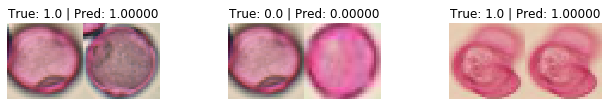

In [106]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)

# Prediction 

In [35]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift, OPTICS, Birch
from sklearn import metrics
from sklearn import preprocessing

In [122]:
loaded_model= load_model('SiameseNN_baseline_hard_triplet.hdf5', compile=False)

In [268]:
siamese = load_model("SiameseNN_fine_tuning_stylegan_65k_triplet_aug2.hdf5", compile=False)
initial_learning_rate = 1e-1
optimizer =  Adam(lr=initial_learning_rate)
siamese.compile(loss=triplet_loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])

In [280]:
siamese = load_model("SiameseNN_baseline_contrastive_aug3.hdf5", compile=False)
initial_learning_rate = 1e-1
optimizer =  Adam(lr=initial_learning_rate)
siamese.compile(loss=triplet_loss, optimizer=optimizer, metrics=["accuracy",
                                           tfa.metrics.F1Score(num_classes=1, average='macro')])

In [281]:
X_encode = siamese.layers[2](pollen)

In [101]:
X_encode.shape

TensorShape([4335, 50])

In [352]:
centroids, centroid_labels = get_key_points()

In [328]:
centroids, centroid_labels = get_centroids()

In [256]:
np.unique(centroid_labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [184]:
X_val_encode = siamese.layers[2](pollen_X_val)

In [106]:
X_encode.shape

TensorShape([3312, 50])

In [270]:
X_gan_encode = []
for i in range(104):
    X_encode_i = siamese.layers[2](pollen_gan[625*(i):625*(i+1)])
    X_gan_encode.append(X_encode_i)
X_gan_encode = np.array(X_gan_encode)    

In [271]:
X_gan_encode = X_gan_encode.reshape((len(pollen_gan),50))

In [43]:
X_gan_encode.shape

(65000, 50)

In [44]:
X_encode = X_gan_encode

In [31]:
max_rand, max_adj, i_rand, i_adj = 0,0,-1,-1
for i in range(13,200):
    kmeans = KMeans(n_clusters=i, random_state=0, max_iter=2000, algorithm='elkan').fit(preprocessing.normalize(X_encode))
    rand = metrics.rand_score(target, kmeans.labels_)
    adj = metrics.adjusted_rand_score(target, kmeans.labels_)
    if rand > max_rand:
        max_rand = rand
        i_rand = i
    if adj > max_adj:
        max_adj = adj
        i_adj = i        
    print(i,adj,rand)

13 0.6155007474274987 0.9281152927512887
14 0.6142044328366526 0.9291514013455369
15 0.6093180632529274 0.929648025831039
16 0.6073644552852588 0.9323831993194986
17 0.6058308050557725 0.9318739905190866
18 0.5808949881623897 0.9303841170625802
19 0.5821984089124679 0.9290231872385563
20 0.5738691987260534 0.9318245651663245
21 0.5668171746234248 0.9295212707750625
22 0.5735327463599528 0.9308865777520985
23 0.5564647862531142 0.9308677924704214
24 0.5626919786609536 0.9303739037055518
25 0.5388369429557972 0.9311942551325767
26 0.5344300210660698 0.9308426238406016
27 0.5174106561784537 0.93134873215763
28 0.5208579241893333 0.9299919971052428
29 0.46975267340020765 0.9261939049603357
30 0.45760399984546946 0.92558420402202
31 0.47301749286518163 0.9248364403824465
32 0.465277362781259 0.9267705948696848
33 0.4773162826883805 0.9262624803575259
34 0.4484257828426674 0.9254787875869777
35 0.4583554653017088 0.925536602483013
36 0.45838834753854907 0.9251359106010268
37 0.45488005547589

KeyboardInterrupt: 

In [131]:
i_rand, i_adj

(13, 13)

In [146]:
kmeans = KMeans(n_clusters=200, random_state=0, max_iter=2000, algorithm='elkan').fit(preprocessing.normalize(X_encode))

In [133]:
metrics.adjusted_rand_score(target, kmeans.labels_)

0.8553196232724565

In [47]:
metrics.rand_score(target, kmeans.labels_)

0.9153673817475637

In [177]:
affclustering = AffinityPropagation(max_iter=2000, verbose=True, convergence_iter=13).fit(preprocessing.normalize(X_encode))
metrics.rand_score(target, affclustering.labels_)

KeyboardInterrupt: 

In [259]:
centroids, centroid_labels = get_centroids()

In [282]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2,verbose=1, perplexity=25, n_iter=2000, learning_rate=200)

# X = X_gan_encode
# X = np.append(X, X_encode, axis=0)
# X = preprocessing.normalize(X)

# X = X_val_encode
# X = np.append(X, X_encode, axis=0)
# X = preprocessing.normalize(X)

X = preprocessing.normalize(X_encode)
# centroids_norm = preprocessing.normalize(centroids)
# print(X.shape)
# X = np.append(X, centroids_norm, axis=0)
X_embedded = tsne_model.fit_transform(X)
X_embedded.shape

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 4335 samples in 0.000s...
[t-SNE] Computed neighbors for 4335 samples in 0.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4335
[t-SNE] Computed conditional probabilities for sample 2000 / 4335
[t-SNE] Computed conditional probabilities for sample 3000 / 4335
[t-SNE] Computed conditional probabilities for sample 4000 / 4335
[t-SNE] Computed conditional probabilities for sample 4335 / 4335
[t-SNE] Mean sigma: 0.034300
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.405998
[t-SNE] KL divergence after 2000 iterations: 0.833529


(4335, 2)

In [103]:
X_embedded[0:].shape

(4335, 2)

In [146]:
english_to_latin

dict_values(['Salix', 'Tilia', 'Alnus', 'Betula', 'Urtica', 'Amaranthus', 'Plantago', 'Rumex', 'Poaceae', 'Pinus', 'Acer', 'Corylus', 'Artemisia'])

In [168]:
np.unique(target_gan)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [169]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [165]:
len(target_gan[target_gan==0])

5000

In [219]:
len(target)

4335

In [229]:
english_to_latin

{'willow': 'Salix',
 'linden': 'Tilia',
 'alder': 'Alnus',
 'birch': 'Betula',
 'nettle': 'Urtica',
 'pigweed': 'Amaranthus',
 'plantain': 'Plantago',
 'sorrel': 'Rumex',
 'grass': 'Poaceae',
 'pine': 'Pinus',
 'maple': 'Acer',
 'hazel': 'Corylus',
 'mugwort': 'Artemisia'}

In [266]:
di.keys()

dict_keys(['Acer', 'Alnus', 'Artemisia', 'Betula', 'Chenopodiaceae', 'Corylus', 'Pinus', 'Plantago', 'Poaceae', 'Rumex', 'Salix', 'Tilia', 'Urtica'])

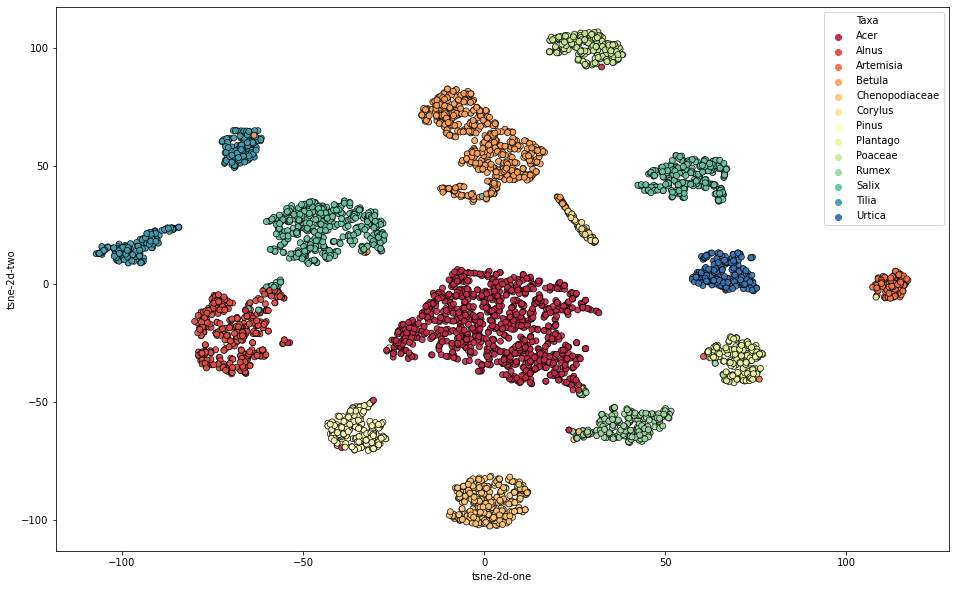

In [283]:
#K-means centroids
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd



N = 0#len(pollen_gan)
feat_cols = [ 'pixel'+str(i) for i in range(X_embedded.shape[1]) ]
plt.figure(figsize=(16,10))

# df = pd.DataFrame(X_embedded[:N],columns=feat_cols)
# df['y'] = target_gan #pollen_y_val 
# # df['label'] = df['y'].apply(lambda i: labels[i])#str(i))
# df['tsne-2d-one'] = X_embedded[:N,0]
# df['tsne-2d-two'] = X_embedded[:N,1]

# ax = sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("Spectral", 13), #14
#     data=df,
#     edgecolor='white',
#     legend="full",
#     alpha=0.9
# )
# # labels = list(english_to_latin.values())
    

# centers = X_embedded[-len(kmeans.cluster_centers_):,:]
df1 = pd.DataFrame(X_embedded[N:],columns=feat_cols)
df1['y'] = target
# df1['label'] = df1['y'].apply(lambda i: labels[i])#str(i))
df1['tsne-2d-one'] = X_embedded[N:,0]
df1['tsne-2d-two'] = X_embedded[N:,1]

ax = sns.scatterplot( 
    x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("Spectral", 13), #14
        data=df1,
        edgecolor='black',
        legend="full",
        alpha=0.9)
labels = list(di.keys())
legend = ax.legend_
legend.get_texts()[0].set_text('Taxa')
for i, label in enumerate(labels):
    # i+1 because i=0 is the title, and i starts at 0
    legend.get_texts()[i+1].set_text(label) 
# plt.show()
plt.savefig('pic/contrastive.png', bbox_inches='tight', pad_inches=0)        

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

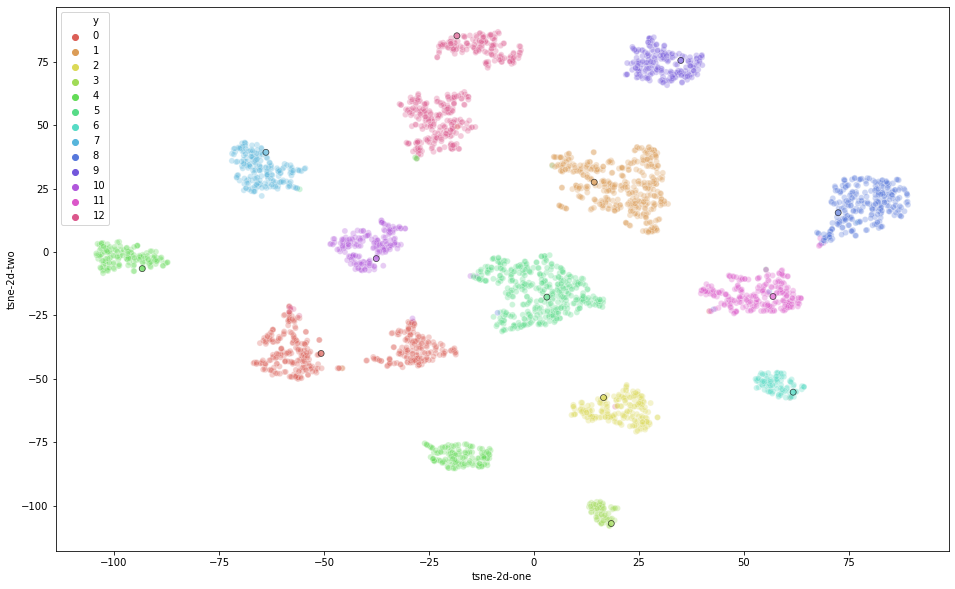

In [333]:
#K-means centroids
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd



N = len(pollen)
feat_cols = [ 'pixel'+str(i) for i in range(X_embedded.shape[1]) ]

df = pd.DataFrame(X_embedded[:N],columns=feat_cols)
df['y'] = target  #target_gan
df['label'] = df['y'].apply(lambda i: str(i))
df['tsne-2d-one'] = X_embedded[:N,0]
df['tsne-2d-two'] = X_embedded[:N,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 13), #14
    data=df,
    legend="full",
    alpha=0.3
)

# centers = X_embedded[-len(kmeans.cluster_centers_):,:]
df1 = pd.DataFrame(X_embedded[N:],columns=feat_cols)
df1['y'] = np.array(centroid_labels).astype('int')
df1['label'] = df1['y'].apply(lambda i: str(i))
df1['tsne-2d-one'] = X_embedded[N:,0]
df1['tsne-2d-two'] = X_embedded[N:,1]

sns.scatterplot( 
    x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", 13), #14
        data=df1,
        edgecolor='black',
        legend=False,
        alpha=0.7)

In [252]:
np.unique(np.array(centroid_labels).astype('int'))

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12])

In [253]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

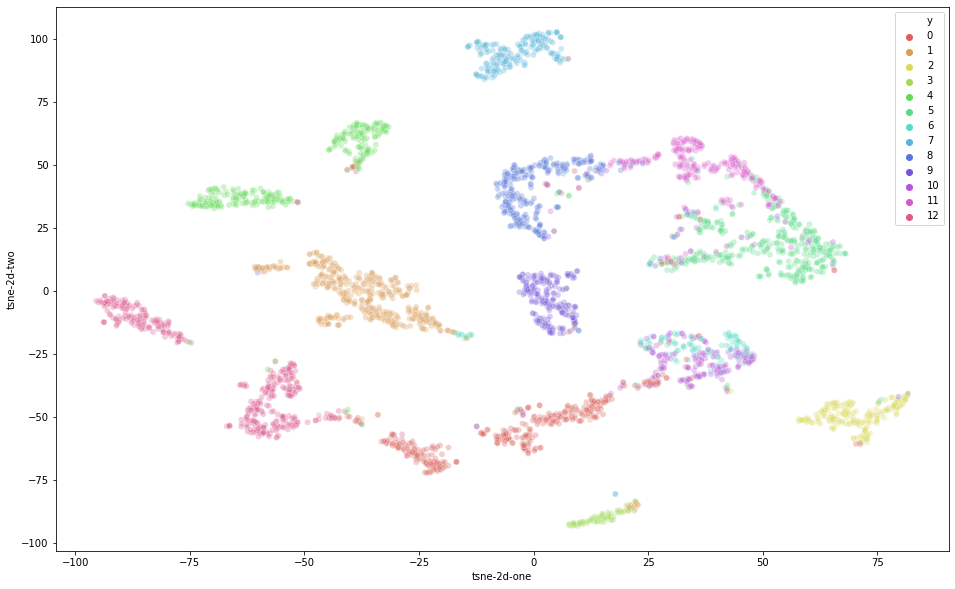

In [181]:
#K-means centroids
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

N = 10000
feat_cols = [ 'pixel'+str(i) for i in range(X_embedded.shape[1]) ]
df = pd.DataFrame(X_embedded,columns=feat_cols)
df['y'] = target
df['label'] = df['y'].apply(lambda i: str(i))
df['tsne-2d-one'] = X_embedded[:,0]
df['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 13), #14
    data=df,
    legend="full",
    alpha=0.3
)
# # centers = X_embedded[-len(kmeans.cluster_centers_):,:]
# df1 = pd.DataFrame(X_embedded[65000:],columns=feat_cols)
# df1['y'] = target
# df1['label'] = df1['y'].apply(lambda i: str(i))
# df1['tsne-2d-one'] = X_embedded[65000:,0]
# df1['tsne-2d-two'] = X_embedded[65000:,1]

# s = sns.scatterplot( 
#     x="tsne-2d-one", y="tsne-2d-two",
#         hue="y",
#         palette=sns.color_palette("hls", 13), #14
#         data=df1,
#         edgecolor='black',
#         legend=False,
#         alpha=0.7)

In [151]:
centroids = kmeans.cluster_centers_
centroid_labels = np.zeros(len(kmeans.cluster_centers_))
centroids_tsne = X_embedded[-(len(kmeans.cluster_centers_)):]
for j in range(len(kmeans.cluster_centers_)):
    min = 100000
    for i in range(X_embedded.shape[0]-len(kmeans.cluster_centers_)):
        dist = np.linalg.norm(centroids_tsne[j]-X_embedded[i])
        if min > dist:
            min = dist
            centroid_labels[j] = target[i]
print(np.sort(centroid_labels))            

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12.]


In [154]:
centroids = kmeans.cluster_centers_
centroid_labels = np.zeros(len(kmeans.cluster_centers_))
X_norm = preprocessing.normalize(X_encode)
for j in range(len(kmeans.cluster_centers_)):
    min = float("inf")
    for i in range(X_norm.shape[0]):
        dist = np.linalg.norm(centroids[j]-X_norm[i])
        if min > dist:
            min = dist
            centroid_labels[j] = target[i]
print(np.sort(centroid_labels))            

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  4.  4.  4.  4.  4.
  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12.]


In [ ]:
#Affinity centroids
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

N = 10000
feat_cols = [ 'pixel'+str(i) for i in range(X_embedded.shape[1]) ]
df = pd.DataFrame(X_embedded,columns=feat_cols)
df['y'] = np.append(target,centroid_labels)
df['label'] = df['y'].apply(lambda i: str(i))
# df_subset = df.loc[rndperm[:N],:].copy()
df['tsne-2d-one'] = X_embedded[:,0]
df['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 13),
    data=df,
    legend="full",
    alpha=0.3
)
centers = X_embedded[affclustering.cluster_centers_indices_,:]
# tsne_model.fit_transform(kmeans_model.cluster_centers_)
sns.scatterplot(centers[:, 0],centers[:, 1], 
        s=250, marker='*', label='centroids',
        edgecolor='black',
       palette=sns.color_palette("hls", 13))

In [ ]:
centroids = X_encode[affclustering.cluster_centers_indices_]#affclustering.cluster_centers_
centroid_labels = target[affclustering.cluster_centers_indices_]
print(np.sort(centroid_labels))

In [48]:
print(evaluate(centroids, centroid_labels))

11 1
3 9
1 11
4 0
7 7
7 5
4 0
7 5
7 7
3 9
3 12
7 5
3 12
3 12
7 7
11 1
11 1
3 1
11 1
11 1
11 1
11 1
3 12
12 8
7 0
1 2
4 0
3 12
7 5
2 5
3 4
7 5
7 11
11 1
2 3
7 6
11 1
7 5
3 4
3 8
4 0
2 6
10 8
0 2
11 1
4 0
3 12
3 12
7 7
7 5
7 5
7 5
0 0
4 1
7 11
3 12
3 12
11 1
3 4
3 11
11 1
7 5
11 1
3 8
7 5
7 5
7 10
7 5
3 8
11 1
7 5
11 1
7 7
7 5
3 6
3 8
3 12
7 10
7 0
0 2
7 5
11 1
3 8
7 10
0 0
1 11
11 1
3 9
3 4
7 11
4 0
7 5
11 1
3 9
2 6
6 2
7 0
11 1
7 10
7 3
11 1
3 4
4 0
3 4
4 0
7 5
7 10
3 9
3 5
7 5
3 4
11 1
7 5
7 5
3 12
0 2
7 5
3 12
7 7
7 5
7 10
7 5
7 5
7 11
11 1
7 5
3 12
3 11
4 0
3 12
11 1
7 10
7 10
7 0
11 1
3 4
3 4
7 0
7 10
1 6
11 1
7 5
7 11
2 1
3 12
7 11
7 7
3 12
1 9
3 12
11 1
3 4
4 0
7 5
7 5
3 4
3 4
7 7
2 9
7 11
11 1
12 5
7 5
11 1
11 1
7 5
7 5
3 12
3 9
7 11
11 1
4 0
7 8
7 5
7 5
7 5
4 0
3 12
12 8
3 4
7 5
3 0
11 1
6 12
3 4
6 12
0 2
3 12
7 10
3 12
7 5
7 5
3 12
11 1
3 12
7 0
7 5
11 1
7 5
7 7
7 5
2 1
3 12
4 0
7 10
6 12
3 4
7 11
3 12
3 12
3 12
3 4
1 8
7 11
3 12
4 0
11 1
7 5
11 1
3 12
7 5
6 12
3 4
4 0
4 12
3 

In [ ]:
import io
import scipy as sp
def get_class_cos(imgio):
#     y_pred=np.zeros((1,n_types))
    y_pred = -1
    mb_x_i = imgio
    feed_dict = {
             x_i: np.expand_dims(np.expand_dims(mb_x_i,0),0)
    }
    x_encode = sess.run([x_i_encode],feed_dict=feed_dict)
    x_i_inv_mag = np.reciprocal(np.sqrt(np.clip
                                (np.sum(np.square(x_encode),1,keepdims=True),
                                                  eps,float("inf"))))    
    min = float("inf")
    cos_sim_list = []
    for i,x1 in enumerate(centroids):
        x = np.expand_dims(x1,0)
        x_hat_inv_mag = np.reciprocal(np.sqrt(np.clip
                                            (np.sum(np.square(x),1,keepdims=True),
                                                              eps,float("inf"))))        
        dotted = np.squeeze(
                np.matmul(np.expand_dims(x,1),np.expand_dims(x_encode,2)))
        cos_sim = 1 - dotted * x_i_inv_mag * x_hat_inv_mag
        cos_sim_list.append(cos_sim)
        if abs(cos_sim) < min:
            min = abs(cos_sim)
            y_pred = centroid_labels[i]
#     cos_sim = np.concat(cos_sim_list,1)    
#         weighting = sp.softmax(cos_sim)
#         label_prob = np.squeeze(np.matmul(np.expand_dims(weighting,1),y_i))     
#         y_pred[i,:] = label_prob
#     y_pred_mean = np.mean(y_pred,axis=0)

    return y_pred#np.argmax(y_pred)   

In [ ]:
import scipy as sp
def get_class_euc(imgio):
#     y_pred=np.zeros((1,n_types))
    y_pred = -1
    mb_x_i = imgio
    feed_dict = {
             x_i: np.expand_dims(np.expand_dims(mb_x_i,0),0)
    }
    x_encode = sess.run([x_i_encode],feed_dict=feed_dict)
    x_norm = preprocessing.normalize(x_encode)
    
    min = float("inf")
    dist_list = []
    for i,x1 in enumerate(centroids):
        x = preprocessing.normalize(np.expand_dims(x1,0))
        dist = np.linalg.norm(x - x_norm)
        if min > dist:
            min = dist
            y_pred = centroid_labels[i]
        dist_list.append(dist)
#     cos_sim = np.concat(cos_sim_list,1)    
#         weighting = sp.softmax(cos_sim)
#         label_prob = np.squeeze(np.matmul(np.expand_dims(weighting,1),y_i))     
#         y_pred[i,:] = label_prob
#     y_pred_mean = np.mean(y_pred,axis=0)

    return y_pred#np.argmax(y_pred)   

In [ ]:
import scipy as sp
def get_class(imgio, centroids, centroid_labels):
    X_encode = siamese.layers[2](tf.expand_dims(imgio,0))
    y_pred = -1 
    max = 0
    for i,x1 in enumerate(centroids):
        x = siamese.layers[3]([X_encode, tf.expand_dims(x1,0)])
        x = siamese.layers[4](x)
        prob = siamese.layers[5](x)
        if max < prob.numpy():
            max = prob.numpy()
#             print(prob.numpy())
            y_pred = centroid_labels[i]
    return y_pred

In [67]:
import scipy as sp
def get_class_softmax(imgio):
    X_encode = embedding_network(tf.expand_dims(imgio,0))
    y_pred=np.zeros(len(centroids))
    max = 0
    for i,x1 in enumerate(centroids):
        x = siamese.layers[3]([X_encode, tf.expand_dims(x1,0)])
        x = siamese.layers[4](x)
        prob = siamese.layers[5](x)
        y_pred[i] = prob
    ids = range(int(centroid_labels.max()+1)) #array of unique ids
    pos_mean = [np.mean(y_pred[centroid_labels == i]) for i in ids]
    
#     weighting = sp.special.softmax(pos_mean)
    return np.argmax(pos_mean)